# Behaviour analysis using Deep Learning
Click here to skip the imports and functions: [Start](#Start-here)

### Imports

You can use the cell directly below (by uncommenting it) to install the required packages before importing them. \
You should consider installing these in a new environment to avoid potential conflicting dependencies with existing packages.

In [1]:
# !pip install numpy matplotlib umap-learn hdbscan scikit-learn pandas opencv-python imageio ipywidgets joblib torch holoviews statesegmentation seaborn bokeh networkx --user

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from umap import UMAP
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import math
import os
import cv2
import imageio
from IPython.display import display, Image
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, Video
import joblib
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import holoviews as hv
from holoviews import opts, dim
from statesegmentation import GSBS
from matplotlib import patches
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from matplotlib.colors import to_hex
from bokeh.plotting import show
import networkx as nx

### Functions

#### Data transformation

In [3]:
def transform_mousecentric(df, main_dir, mouse, freezing_frame_dict):
    '''
    Transforms data into mouse-centric version.

    Parameters:
    df (pd.DataFrame): The input data.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric version.
    '''
    
    folder_path = main_dir + "/Datasets/MouseCentric"
    file_path = f'/{mouse}_MouseCentric_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mc_df = df.copy()
        mc_df = mc_df.iloc[:, 1:-2]
        mc_df = mc_df.astype(float)

        s1_x = mc_df.iloc[:,39].copy()
        s1_y = mc_df.iloc[:,40].copy()

        coordinates_columns = [col for col in mc_df.columns if 'x' in col or 'y' in col]

        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mc_df[col_x]
            y = mc_df[col_y]

            transformed_x = x - s1_x
            transformed_y = y - s1_y

            mc_df[col_x] = transformed_x
            mc_df[col_y] = transformed_y

        mc_df.iloc[:,39]=s1_x
        mc_df.iloc[:,40]=s1_y
        mc_df.insert(0, 'frame_number', df['frame_number'])
        mc_df['mouse_no'] = float(mouse)
        mc_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        mc_df = pd.read_csv(folder_path + file_path)
        
    return mc_df
    
def transform_changecoord(df, main_dir, mouse, freezing_frame_dict):
    '''
    Transforms data into change coordinate version.

    Parameters:
    df (pd.DataFrame): The input data.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.

    Returns:
    pd.DataFrame: Transformed data in change coordinate version.
    '''
    folder_path = main_dir + "/Datasets/ChangeCoords"
    file_path = f'/{mouse}_ChangeCoords_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        cc_df = df.copy()
        cc_df = cc_df.iloc[:, 1:-2]
        cc_df = cc_df.astype(float)

        coordinates_columns = [col for col in cc_df.columns if 'x' in col or 'y' in col]

        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            cc_df[col_x] = cc_df[col_x] - cc_df[col_x].shift(1)
            cc_df[col_y] = cc_df[col_y] - cc_df[col_y].shift(1)

            cc_df[col_x] = cc_df[col_x].fillna(0)
            cc_df[col_y] = cc_df[col_y].fillna(0)

        cc_df.insert(0, 'frame_number', df['frame_number'])
        cc_df['mouse_no'] = float(mouse)
        cc_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        cc_df.to_csv(folder_path + file_path, index=False)
        
    else:
        cc_df = pd.read_csv(folder_path + file_path)
    return cc_df
    
def transform_mcpolar(mc_df, main_dir, mouse, freezing_frame_dict):
    '''
    Transforms data into mouse-centric polar coordinates version.

    Parameters:
    mc_df (pd.DataFrame): The input data in mouse-centric coordinates.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric polar coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseCentricPolar"
    file_path = f'/{mouse}_MouseCentricPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        mcp_df = mc_df.copy()
        mcp_df = mcp_df.iloc[:,1:-2]
        mcp_df = mcp_df.astype(float)
        
        coordinates_columns = [col for col in mcp_df.columns if 'x' in col or 'y' in col]

        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mcp_df[col_x]
            y = mcp_df[col_y]

            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)

            mcp_df[col_x] = r
            mcp_df[col_y] = theta

        mcp_df.insert(0, 'frame_number', mc_df['frame_number'])
        mcp_df['mouse_no'] = float(mouse)
        mcp_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mcp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mcp_df = pd.read_csv(folder_path + file_path)
    
    return mcp_df
    
def transform_mcdirectional(mc_df, mcp_df, main_dir, mouse, freezing_frame_dict):
    '''
    Transforms data into mouse-centric directional coordinates version.

    Parameters:
    mc_df (pd.DataFrame): The input data in mouse-centric coordinates.
    mcp_df (pd.DataFrame): The data in mouse-centric polar coordinates for reference.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric directional coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseDirectional"
    file_path = f'/{mouse}_MouseDirectional_data.csv'
    if not os.path.exists(folder_path + file_path):
    
        md_df = mc_df.copy()
        md_df = md_df.iloc[:,1:-2]
        md_df = md_df.astype(float)

        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]

        for frame_number, frame_data_polar in mcp_df.groupby('frame_number'):

            rotation_angle = frame_data_polar.at[frame_data_polar.index[0], "('S2', 'y')"]
            affine_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                      [np.sin(rotation_angle), np.cos(rotation_angle)]])

            for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):

                x = md_df[col_x]
                y = md_df[col_y]

                points = np.column_stack((x, y))
                transformed_points = np.dot(points[frame_number], affine_matrix)

                md_df.at[frame_number, col_x] = transformed_points[0]
                md_df.at[frame_number, col_y] = transformed_points[1]

        md_df.insert(0, 'frame_number', mc_df['frame_number'])
        md_df['mouse_no'] = float(mouse)
        md_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        md_df.to_csv(folder_path + file_path, index=False)
    
    else:
        md_df = pd.read_csv(folder_path + file_path)
    
    return md_df

def transform_mcdirectionalpolar(md_df, main_dir, mouse, freezing_frame_dict):
    '''
    Transforms data into mouse-centric directional polar coordinates version.

    Parameters:
    md_df (pd.DataFrame): The input data in mouse-centric directional coordinates.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.

    Returns:
    pd.DataFrame: Transformed data in mouse-centric directional polar coordinates.
    '''
    folder_path = main_dir + "/Datasets/MouseDirectionalPolar"
    file_path = f'/{mouse}_MouseDirectionalPolar_data.csv'
    if not os.path.exists(folder_path + file_path):
        
        mdp_df = md_df.copy()
        mdp_df = mdp_df.iloc[:,1:-2]
        mdp_df = mdp_df.astype(float)
        
        coordinates_columns = [col for col in md_df.columns if 'x' in col or 'y' in col]
        
        for col_x, col_y in zip(coordinates_columns[::2], coordinates_columns[1::2]):
            x = mdp_df[col_x]
            y = mdp_df[col_y]
            
            r = np.sqrt(x**2, y**2)
            theta = np.arctan2(y, x)
            
            mdp_df[col_x] = r
            mdp_df[col_y] = theta
            
        mdp_df.insert(0, 'frame_number', md_df['frame_number'])
        mdp_df['mouse_no'] = float(mouse)
        mdp_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        mdp_df.to_csv(folder_path + file_path, index=False)
    
    else:
        mdp_df = pd.read_csv(folder_path + file_path)
    
    return mdp_df

def create_dataset(main_dir: str, datatype: str):
    '''
    Create data files with the given transformation type from the original data in the given main directory.

    Parameters:
    main_dir (str): The main directory containing the original data and transformation results.
    datatype (str): The type of data transformation to apply.

    Returns:
    pd.DataFrame: The dataset created based on the specified data transformation.

    Supported 'datatype' values:
    - "Original": Original data.
    - "MouseCentric": Mouse-centric data.
    - "MouseCentricPolar": Mouse-centric polar data.
    - "ChangeCoord": Data with changed coordinates.
    - "MouseDirectional": Mouse-centric directional data.
    - "MouseDirectionalPolar": Mouse-centric directional polar data.
    '''
    folder_path = main_dir + "/Datasets/Original"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    dataframes = []
    
    freezing_frame_dict = pd.read_pickle(main_dir + "/Datasets/Freezing_predictions_dict.pkl")
    
    filtered_dir = os.path.join(main_dir, 'filtered')
    files = os.listdir(filtered_dir)
    
    for file in tqdm(files, desc="Processing Files"):
        mouse=file.split("_")[1]+"."+file.split("_")[2][0:-3]
        file=os.path.join(main_dir+'/filtered/', file)
        
        new_file_path = f'/{mouse}_Original_data.csv'
        if not os.path.exists(folder_path + new_file_path):
            df = pd.read_csv(file,header=[1,2])
            df.columns = ['frame_number'] + list(df.columns[1:])
            df['mouse_no'] = float(mouse)
            df['freezing_label'] = freezing_frame_dict[mouse]
            
            df.to_csv(folder_path + new_file_path, index=False)
        else:
            df = pd.read_csv(folder_path + new_file_path)

        if datatype == "Original":
            dataframes.append(df)
        elif datatype == "MouseCentric":
            mc_df = transform_mousecentric(df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(mc_df)
        elif datatype == "MouseCentricPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse, freezing_frame_dict)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(mcp_df)
        elif datatype == "ChangeCoord":
            cc_df = transform_changecoord(df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(cc_df)
        elif datatype == "Features":
            feat_df = feature_selection(df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(feat_df)
        elif datatype == "MouseDirectional":
            mc_df = transform_mousecentric(df, main_dir, mouse, freezing_frame_dict)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse, freezing_frame_dict)
            mcd_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(mcd_df)
        elif datatype == "MouseDirectionalPolar":
            mc_df = transform_mousecentric(df, main_dir, mouse, freezing_frame_dict)
            mcp_df = transform_mcpolar(mc_df, main_dir, mouse, freezing_frame_dict)
            md_df = transform_mcdirectional(mc_df, mcp_df, main_dir, mouse, freezing_frame_dict)
            mdp_df = transform_mcdirectionalpolar(md_df, main_dir, mouse, freezing_frame_dict)
            dataframes.append(mdp_df)
    
    dataset = pd.concat(dataframes, ignore_index=True)
    drop_cols = [col for col in dataset.columns if 'likelihood' in col]
    dataset = dataset.drop(drop_cols, axis=1)
    
    return dataset

In [4]:
def angle3pt(ax, ay, bx, by, cx, cy):
    ang = math.degrees(
        math.atan2(cy - by, cx - bx) - math.atan2(ay - by, ax - bx))
    return ang + 360 if ang < 0 else ang

def feature_selection(df, main_dir, mouse, freezing_frame_dict):
    '''
    Extracts features from data to use as dataset
    
    Parameters:
    df (pd.DataFrame): The input data.
    main_dir (str): The main directory containing transformation results.
    mouse (str): Mouse identifier.
    freezing_frame_dict (dict): Dictionary of freezing frame labels for each mouse.
    
    Returns:
    pd.DataFrame: Dataset containing (only) extracted features
    '''
    folder_path = main_dir + "/Datasets/Features"
    file_path = f'/{mouse}_Features_data.csv'
    if not os.path.exists(folder_path + file_path):
        
        df_copy = df.copy()
        df_copy = df_copy.iloc[:, 1:-2]
        df_copy = df_copy.astype(float)
        
        feat_df = pd.DataFrame()
        
        columnHeaders = ["Mouse_nose_x", "Mouse_nose_y", "Mouse_nose_p", \
                         "Mouse_H1R_x", "Mouse_H1R_y", "Mouse_H1R_p", \
                         "Mouse_H2R_x", "Mouse_H2R_y", "Mouse_H2R_p", \
                         "Mouse_H1L_x", "Mouse_H1L_y", "Mouse_H1L_p", \
                         "Mouse_H2L_x", "Mouse_H2L_y", "Mouse_H2L_p", \
                         "Mouse_B1R_x", "Mouse_B1R_y", "Mouse_B1R_p", \
                         "Mouse_B2R_x", "Mouse_B2R_y", "Mouse_B2R_p", \
                         "Mouse_B3R_x", "Mouse_B3R_y", "Mouse_B3R_p", \
                         "Mouse_B1L_x", "Mouse_B1L_y", "Mouse_B1L_p", \
                         "Mouse_B2L_x", "Mouse_B2L_y", "Mouse_B2L_p", \
                         "Mouse_B3L_x", "Mouse_B3L_y", "Mouse_B3L_p", \
                         "Mouse_tail_x", "Mouse_tail_y", "Mouse_tail_p", \
                         "Mouse_S2_x", "Mouse_S2_y", "Mouse_S2_p", \
                         "Mouse_S1_x", "Mouse_S1_y", "Mouse_S1_p"]
        df_copy.columns = columnHeaders
        df_copy['Mouse_poly_area'] = df_copy.apply(lambda x: ConvexHull(np.array(
            [[x['Mouse_nose_x'], x["Mouse_nose_y"]],
             [x['Mouse_H1R_x'], x["Mouse_H1R_y"]],
             [x['Mouse_H2R_x'], x["Mouse_H2R_y"]],
             [x['Mouse_H1L_x'], x["Mouse_H1L_y"]], 
             [x['Mouse_H2L_x'], x["Mouse_H2L_y"]],
             [x['Mouse_B1R_x'], x["Mouse_B1R_y"]],
             [x['Mouse_B2R_x'], x["Mouse_B2R_y"]],
             [x['Mouse_B3R_x'], x["Mouse_B3R_y"]],
             [x['Mouse_B1L_x'], x["Mouse_B1L_y"]],
             [x['Mouse_B2L_x'], x["Mouse_B2L_y"]],
             [x['Mouse_B3L_x'], x["Mouse_B3L_y"]],
             [x['Mouse_tail_x'], x["Mouse_tail_y"]],
             [x['Mouse_S2_x'], x["Mouse_S2_y"]],
             [x['Mouse_S1_x'], x["Mouse_S1_y"]]])).area, axis=1)
        feat_df['Mouse_poly_area'] = df_copy['Mouse_poly_area'].copy()
        
        df_copy_shifted = df_copy.shift(periods=1)
        df_copy['Movement_nose'] = np.sqrt((df_copy_shifted.Mouse_nose_x - df_copy.Mouse_nose_x) ** 2 + ((df_copy_shifted.Mouse_nose_y - df_copy.Mouse_nose_y) ** 2))
        df_copy['Movement_tail'] = np.sqrt((df_copy_shifted.Mouse_tail_x - df_copy.Mouse_tail_x) ** 2 + ((df_copy_shifted.Mouse_tail_y - df_copy.Mouse_tail_y) ** 2))
        df_copy['Movement_H1L'] = np.sqrt((df_copy_shifted.Mouse_H1L_x - df_copy.Mouse_H1L_x) ** 2 + (df_copy_shifted.Mouse_H1L_y - df_copy.Mouse_H1L_y) ** 2)
        df_copy['Movement_H1R'] = np.sqrt((df_copy_shifted.Mouse_H1R_x - df_copy.Mouse_H1R_x) ** 2 + (df_copy_shifted.Mouse_H1R_y - df_copy.Mouse_H1R_y) ** 2)
        df_copy['Movement_H2L'] = np.sqrt((df_copy_shifted.Mouse_H2L_x - df_copy.Mouse_H2L_x) ** 2 + (df_copy_shifted.Mouse_H2L_y - df_copy.Mouse_H2L_y) ** 2)
        df_copy['Movement_H2R'] = np.sqrt((df_copy_shifted.Mouse_H2R_x - df_copy.Mouse_H2R_x) ** 2 + (df_copy_shifted.Mouse_H2R_y - df_copy.Mouse_H2R_y) ** 2)
        df_copy['Movement_B1L'] = np.sqrt((df_copy_shifted.Mouse_B1L_x - df_copy.Mouse_B1L_x) ** 2 + (df_copy_shifted.Mouse_B1L_y - df_copy.Mouse_B1L_y) ** 2)
        df_copy['Movement_B1R'] = np.sqrt((df_copy_shifted.Mouse_B1R_x - df_copy.Mouse_B1R_x) ** 2 + (df_copy_shifted.Mouse_B1R_y - df_copy.Mouse_B1R_y) ** 2)
        df_copy['Movement_B2L'] = np.sqrt((df_copy_shifted.Mouse_B2L_x - df_copy.Mouse_B2L_x) ** 2 + (df_copy_shifted.Mouse_B2L_y - df_copy.Mouse_B2L_y) ** 2)
        df_copy['Movement_B2R'] = np.sqrt((df_copy_shifted.Mouse_B2R_x - df_copy.Mouse_B2R_x) ** 2 + (df_copy_shifted.Mouse_B2R_y - df_copy.Mouse_B2R_y) ** 2)
        df_copy['Movement_B3L'] = np.sqrt((df_copy_shifted.Mouse_B3L_x - df_copy.Mouse_B3L_x) ** 2 + (df_copy_shifted.Mouse_B3L_y - df_copy.Mouse_B3L_y) ** 2)
        df_copy['Movement_B3R'] = np.sqrt((df_copy_shifted.Mouse_B3R_x - df_copy.Mouse_B3R_x) ** 2 + (df_copy_shifted.Mouse_B3R_y - df_copy.Mouse_B3R_y) ** 2)
        df_copy['Movement_S1'] = np.sqrt((df_copy_shifted.Mouse_S1_x - df_copy.Mouse_S1_x) ** 2 + ((df_copy_shifted.Mouse_S1_y - df_copy.Mouse_S1_y) ** 2))
        df_copy['Movement_S2'] = np.sqrt((df_copy_shifted.Mouse_S2_x - df_copy.Mouse_S2_x) ** 2 + ((df_copy_shifted.Mouse_S2_y - df_copy.Mouse_S2_y) ** 2))
        
        feat_df['Mouse_polygon_size_change'] = df_copy_shifted.Mouse_poly_area - df_copy.Mouse_poly_area
        movement_columns = [
            'Movement_nose',
            'Movement_tail',
            'Movement_H1L',
            'Movement_H1R',
            'Movement_H2L',
            'Movement_H2R',
            'Movement_B1L',
            'Movement_B1R',
            'Movement_B2L',
            'Movement_B2R',
            'Movement_B3L',
            'Movement_B3R',
            'Movement_S1',
            'Movement_S2']
        feat_df['Movement_S2'] = df_copy['Movement_S2'].copy()
        feat_df['Total_movement_all_bodyparts'] = df_copy[movement_columns].sum(axis=1)
        
        feat_df['Mouse_angle'] = df_copy.apply(lambda x: angle3pt(x['Mouse_nose_x'], x['Mouse_nose_y'], x['Mouse_S2_x'], x['Mouse_S2_y'], x['Mouse_tail_x'], x['Mouse_tail_y']), axis=1)
                
        large_euclidean_list = []
        mean_euclidean_list = []
        for index, row in df_copy.iterrows():
            body_parts_np_array = np.array([
                [row['Mouse_nose_x'], row['Mouse_nose_y']],
                [row['Mouse_H1R_x'], row['Mouse_H1R_y']],
                [row['Mouse_H2R_x'], row['Mouse_H2R_y']],
                [row['Mouse_H1L_x'], row['Mouse_H1L_y']],
                [row['Mouse_H2L_x'], row['Mouse_H2L_y']],
                [row['Mouse_B1R_x'], row['Mouse_B1R_y']],
                [row['Mouse_B2R_x'], row['Mouse_B2R_y']],
                [row['Mouse_B3R_x'], row['Mouse_B3R_y']],
                [row['Mouse_B1L_x'], row['Mouse_B1L_y']],
                [row['Mouse_B2L_x'], row['Mouse_B2L_y']],
                [row['Mouse_B3L_x'], row['Mouse_B3L_y']],
                [row['Mouse_tail_x'], row['Mouse_tail_y']],
                [row['Mouse_S2_x'], row['Mouse_S2_y']],
                [row['Mouse_S1_x'], row['Mouse_S1_y']]]).astype(int)
            
            dist_euclidean = cdist(body_parts_np_array, body_parts_np_array, metric='euclidean')
            large_euclidean = np.amax(dist_euclidean)
            mean_euclidean = np.mean(dist_euclidean)
            large_euclidean_list.append(large_euclidean)
            mean_euclidean_list.append(mean_euclidean)
        feat_df['Largest_euclidean_distance_hull'] = large_euclidean_list
        feat_df['Mean_euclidean_distance_hull'] = mean_euclidean_list
        
        feat_df['Total_movement_all_bodyparts_mean_25'] = feat_df['Total_movement_all_bodyparts'].rolling(25, min_periods=1).mean()
        feat_df['Mean_euclidean_distance_hull_mean_25'] = feat_df['Mean_euclidean_distance_hull'].rolling(25, min_periods=1).mean()
        feat_df['Largest_euclidean_distance_hull_mean_25'] = feat_df['Largest_euclidean_distance_hull'].rolling(25, min_periods=1).mean()
        feat_df['Movement_S2_mean_25'] = feat_df['Movement_S2'].rolling(25, min_periods=1).mean()
        
        feat_df['Total_movement_all_bodyparts_median_25'] = feat_df['Total_movement_all_bodyparts'].rolling(25, min_periods=1).median()
        feat_df['Mean_euclidean_distance_hull_median_25'] = feat_df['Mean_euclidean_distance_hull'].rolling(25, min_periods=1).median()
        feat_df['Largest_euclidean_distance_hull_median_25'] = feat_df['Largest_euclidean_distance_hull'].rolling(25, min_periods=1).median()
        feat_df['Movement_S2_median_25'] = feat_df['Movement_S2'].rolling(25, min_periods=1).median()
        
        feat_df['Total_movement_all_bodyparts_both_deviation'] = (feat_df['Total_movement_all_bodyparts'].mean() - feat_df['Total_movement_all_bodyparts'])
        feat_df['Largest_euclid_distances_hull_deviation'] = (feat_df['Largest_euclidean_distance_hull'].mean() - feat_df['Largest_euclidean_distance_hull'])
        feat_df['Mean_euclid_distances_hull_deviation'] = (feat_df['Mean_euclidean_distance_hull'].mean() - feat_df['Mean_euclidean_distance_hull'])
        feat_df['Movement_deviation_S2'] = (feat_df['Movement_S2'].mean() - feat_df['Movement_S2'])
        feat_df['Polygon_deviation'] = (feat_df['Mouse_poly_area'].mean() - feat_df['Mouse_poly_area'])

        feat_df['Movement_percentile_rank'] = feat_df['Movement_S2'].rank(pct=True)
        feat_df['Total_movement_all_bodyparts_percentile_rank'] = feat_df['Total_movement_all_bodyparts'].rank(pct=True)
        feat_df['Largest_euclid_distances_hull_percentile_rank'] = feat_df['Largest_euclidean_distance_hull'].rank(pct=True)
        feat_df['Mean_euclid_distances_hull_percentile_rank'] = feat_df['Mean_euclidean_distance_hull'].rank(pct=True)
        feat_df['Polygon_percentile_rank'] = feat_df['Mouse_poly_area'].rank(pct=True)
        
        feat_df = feat_df.fillna(0)
        
        feat_df.insert(0, 'frame_number', df['frame_number'])
        feat_df['mouse_no'] = float(mouse)
        feat_df['freezing_label'] = freezing_frame_dict[mouse]
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        feat_df.to_csv(folder_path + file_path, index=False)
        
    else:
        feat_df = pd.read_csv(folder_path + file_path)
    
    return feat_df
        

#### Selecting subset from data

In [5]:
def generate_sub_dataset(dataset, mouse_number=None, frames_per_video=11250):
    """
    Generate a sub-dataset by selecting random videos or videos from a specific mouse
    from the given dataset.

    Args:
    dataset (pd.DataFrame): The original dataset.
    num_videos (int or None): The number of random videos to select. Set to None if specifying a mouse.
    frames_per_video (int): The number of frames per video.
    mouse_number (int or None): The mouse number to select videos for. Set to None for random selection.

    Returns:
    pd.DataFrame: A sub-dataset containing the selected videos.
    """
    if mouse_number is not None:
        # Select videos for a specific mouse
        sub_dataset = dataset[dataset['mouse_no'] == mouse_number]
        print(f'The data for mouse {mouse_number} was extracted.')
        return sub_dataset.reset_index(drop=True)
    else:
        # Generate random video indices
        selected_video_indices = np.random.choice(range(1, 99), size=1, replace=False)

    selected_videos = []

    # Create slices for each selected video
    for video_index in selected_video_indices:
        # Calculate the starting and ending frame indices for the video
        start_frame = video_index * frames_per_video
        end_frame = (video_index + 1) * frames_per_video
        # Use .loc to create a slice by row index
        video_slice = dataset.loc[start_frame:end_frame - 1]
        selected_videos.append(video_slice)

    # Concatenate the selected videos to create a sub-dataset
    sub_dataset = pd.concat(selected_videos, ignore_index=True)
    print("The following mouse was randomly selected: "+ " ".join(map(str, sub_dataset['mouse_no'].unique())))
    return sub_dataset

def get_dataset(main_folder, datatype, mouse_number=None):
    """
    Retrieve a subset of a dataset based on the specified parameters.

    Parameters:
    - main_folder (str): The main folder containing the dataset.
    - datatype (str): The type of data to retrieve from the dataset.
    - mouse_number (int or None, optional): The specific mouse number to filter the dataset.
      If None, the function will retrieve the entire dataset without any mouse number filtering.

    Returns:
    - subset (pd.DataFrame): A subset of the dataset based on the specified parameters.
    """
    dataset = create_dataset(main_folder, datatype)
    subset = generate_sub_dataset(dataset, mouse_number)
    print(f"The shape of the data: {subset.shape[0]} frames by {subset.shape[-1]} columns of which three are identifying columns: \n'frame_number', 'mouse_no', and 'freezing_label'. The rest are features.")
    print("The mouse data has a video rate of 25 frames per second.")
    return subset

In [6]:
def plot_dataframe_heatmap(df, datatype):
    """
    Plot a DataFrame as a heatmap with features on the y-axis and time frames on the x-axis.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with features as columns and time frames as rows.

    Returns:
    - None (displays the heatmap plot).
    """
    drop_cols = ['frame_number', 'mouse_no', 'freezing_label']
    
    # Drop non-feature columns
    df = df.drop(drop_cols, axis=1)
    
    # Get the list of columns and sort them
    cols = df.columns
    
    if datatype != 'Features':
        # Group columns by x and y and concatenate them
        columns_reordered = [col for col in cols if 'x' in col] + [col for col in cols if 'y' in col]

        # Create a new DataFrame with reordered columns
        df_reordered = df[columns_reordered]
    
    else:
        df_reordered = df.copy()
    
    # Transpose the DataFrame
    df_transposed = df_reordered.transpose()
    
    # Apply z-score normalization to each feature
    normalized_data_transposed = zscore(df_transposed, axis=1)
    
    # Set the style for seaborn
    sns.set()

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the first heatmap
    sns.heatmap(df_transposed, cmap='viridis', cbar_kws={'label': 'Feature Values'}, ax=axs[0])
    axs[0].set_xlabel('Time Frames')
    axs[0].set_ylabel('Features')
    axs[0].set_title('Features Per Time Frame')

    # Plot the second heatmap
    sns.heatmap(normalized_data_transposed, cmap='viridis', cbar_kws={'label': 'Normalized Feature Values'}, ax=axs[1])
    axs[1].set_xlabel('Time Frames')
    axs[1].set_ylabel('Features')
    axs[1].set_title('Normalized Features Per Time Frame')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    sns.reset_defaults()

#### PCA and visualisation

In [7]:
def fit_pca_and_hdbscan(dataset, min_clusters=10, max_clusters=40):
    '''
    Finds an optimal HDBSCAN fit on the data whilst keeping a limit on the amount of clusters
    that are obtained with HDBSCAN.
    
    Parameters:
    dataset (pd.DataFrame): The data to apply PCA and clustering on.
    min_clusters (int): Minimum amount of clusters constraint on clustering.
    max_clusters (int): Maximum amount of clusters constraint on clustering.
    
    Returns:
    best_pca_embedding: The PCA result that gave the best silhouette score.
    best_cluster_labels: The cluster labels that gave the ebst silhouette score.
    '''
    hdbscan_param_grid = {'min_cluster_size': np.arange(5, 40, 5),
                      'min_samples': np.arange(5, 40, 5)}
    
    # Generate all possible combinations of hyperparameter values for HDBSCAN
    hdbscan_grid = ParameterGrid(hdbscan_param_grid)
    
    best_score = -1
    best_hdbscan_params = None
    
    # Turn off userwarnings for cleaner outputs
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Grid search loop
    for hdbscan_params in tqdm(hdbscan_grid, total=len(list(hdbscan_grid)), desc="HDBSCAN Parameter Grid Search"):
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(dataset.iloc[:, 1:-2])
        
        # Perform HDBSCAN clustering
        cluster_labels = HDBSCAN(**hdbscan_params).fit_predict(pca_result)
        
        # Check the number of clusters and apply constraints
        num_clusters = len(np.unique(cluster_labels))
        
        # Update best parameters if the amount of clusters is within the set limits
        if num_clusters <= max_clusters and num_clusters >= min_clusters:
            
            # Calculate silhouette score from HDBSCAN clustering
            silhouette = silhouette_score(pca_result, cluster_labels)

            if silhouette > best_score:

                # Calculate reconstruction error
                reconstructed_data = pca.inverse_transform(pca_result)
                error = mean_squared_error(dataset.iloc[:, 1:-2], reconstructed_data)

                # Calculate preservation of distances: trustworthiness and continuity
                # original_distances = pairwise_distances(dataset.iloc[:, 1:-2], metric='euclidean')
                # trustworthiness_measure = trustworthiness(original_distances, umap_embedding, metric='euclidean')
                # continuity_measure = continuity(original_distances, umap_embedding, metric='euclidean')

                # Update best parameters if the current iteration improves the score
                best_score = silhouette
                best_hdbscan_params = hdbscan_params
                best_pca_embedding = pca_result
                best_cluster_labels = cluster_labels
    
    # Reset userwarnings back to default
    warnings.resetwarnings()
    
    if best_hdbscan_params is None:
        print("Sorry no clustering parameters were found for your cluster limits. You can try lowering or raising your cluster amount limits.")
    else:
        print("Best HDBSCAN Parameters:", best_hdbscan_params)
        print(f"\nReconstruction error: {error}")
        # print(f"Preservation of distances: Trustworthiness = {trustworthiness_measure}, continuity = {continuity_measure}")
        print(f"Silhouette score: {best_score}")
        print("\nAmount of clusters:", len(np.unique(best_cluster_labels)))
    
    return best_pca_embedding, best_cluster_labels

In [8]:
def plot_pca_and_hdbscan_results(pca_embedding, cluster_labels, dataset):
    '''
    Plots various results for both PCA and HDBSCAN clustering.
    
    Parameters:
    pca_embedding: Predicted PCA values.
    cluster_labels: HDBSCAN cluster labels.
    dataset (pd.DataFrame): Frame dataset.
    
    Returns:
    None
    '''
    # Plot PCA
    print("These plots show the data spatially reduced using PCA:")
    visualize_pca(pca_embedding)
    
    # Plot HDBSCAN
    print("These plots show the same PCA data but clustered using HDBSCAN:")
    color_mapping = visualize_hdbscan(pca_embedding, cluster_labels)
    
    # Plot barcodes
    print("The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. \nThe barcodes also show the freezing frames using black markers.")
    print("The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). \n- FRC is the percentage of frames within a cluster that are freezing frames. \n- CFC is the percentage of total freezing frames that belong to a specific cluster.")
    data = dataset[:len(cluster_labels)].copy()
    plot_combined_timeline_for_clusters(data, cluster_labels, color_mapping)

In [9]:
def visualize_pca(pca_embedding):
    '''
    Plots the given PCA embedding in a 2D plot if the embedding has 2 components
    and in both 2D and 3D plots if the embedding has 3 components.

    Parameters:
    umap_embedding: Predicted PCA values.

    Returns:
    None
    '''
    
    if pca_embedding.shape[1] == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_embedding[:, 0], pca_embedding[:, 1], alpha=0.1)
        plt.title("UMAP 2D Visualization")
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    elif pca_embedding.shape[1] == 3:
        # 3D plot
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')  # 3D plot
        ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2], alpha=0.1)
        ax.set_title("UMAP 3D Visualization")
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")

        # 2D plot of first 2 dimensions
        ax2 = fig.add_subplot(122)
        ax2.scatter(pca_embedding[:, 0], pca_embedding[:, 1], alpha=0.1)
        ax2.set_title("UMAP 2D Visualization (1st and 2nd dimensions)")
        ax2.set_xlabel("UMAP Dimension 1")
        ax2.set_ylabel("UMAP Dimension 2")
        plt.show()

#### UMAP and visualisation

In [10]:
def fit_umap_and_hdbscan(dataset, min_clusters=10, max_clusters=40, supervised=False):
    '''
    Finds an optimal UMAP fit on the data whilst keeping a limit on the amount of clusters
    that are obtained with HDBSCAN.
    
    Parameters:
    dataset (pd.DataFrame): The data to apply UMAP and clustering on.
    min_clusters (int): Minimum amount of clusters constraint on clustering.
    max_clusters (int): Maximum amount of clusters constraint on clustering.
    supervised (bool): Boolean that determines whether UMAP is fitted supervised or not.
    
    Returns:
    best_umap_embedding: The UMAP result that gave the best silhouette score.
    best_cluster_labels: The cluster labels that gave the ebst silhouette score.
    '''
    y_labels = None
    
    if supervised:
        y_labels = dataset['freezing_label']
    
    # Define parameter grids
    umap_param_grid = {'n_neighbors': [5, 10, 15],
                  'min_dist': [0.1, 0.5, 0.8],
                  'n_components': [2, 3]}

    hdbscan_param_grid = {'min_cluster_size': np.arange(20, 80, 10),
                      'min_samples': np.arange(20, 80, 10)}
    
    best_score = -1
    
    # Turn off userwarnings for cleaner outputs
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Generate all possible combinations of hyperparameter values
    umap_grid = ParameterGrid(umap_param_grid)
    
    # Grid search loop
    for umap_params in tqdm(umap_grid, total=len(list(umap_grid)), desc="UMAP Parameter Grid Search"):
        umap = UMAP(**umap_params)
        umap_embedding = umap.fit_transform(dataset.iloc[:, 1:-2], y=y_labels)

        # Generate all possible combinations of hyperparameter values for HDBSCAN
        hdbscan_grid = ParameterGrid(hdbscan_param_grid)

        for hdbscan_params in hdbscan_grid:

            # Perform HDBSCAN clustering
            cluster_labels = HDBSCAN(**hdbscan_params).fit_predict(umap_embedding)

            # Check the number of clusters and apply constraints
            num_clusters = len(np.unique(cluster_labels))

            # Update best parameters if the amount of clusters is within the set limits
            if num_clusters <= max_clusters and num_clusters >= min_clusters:
                # Calculate silhouette score from HDBSCAN clustering
                silhouette = silhouette_score(umap_embedding, cluster_labels)
                
                if silhouette > best_score:
                    
                    # Calculate reconstruction error
                    reconstructed_data = umap.inverse_transform(umap_embedding)
                    error = mean_squared_error(dataset.iloc[:, 1:-2], reconstructed_data)
                    
                    # Calculate preservation of distances: trustworthiness and continuity
                    # original_distances = pairwise_distances(dataset.iloc[:, 1:-2], metric='euclidean')
                    # trustworthiness_measure = trustworthiness(original_distances, umap_embedding, metric='euclidean')
                    # continuity_measure = continuity(original_distances, umap_embedding, metric='euclidean')
                    
                    # Update best parameters if the current iteration improves the score
                    best_score = silhouette
                    best_UMAP_params = umap_params
                    best_hdbscan_params = hdbscan_params
                    best_umap_embedding = umap_embedding
                    best_cluster_labels = cluster_labels
    
    # Reset userwarnings back to default
    warnings.resetwarnings()
    
    print("Best UMAP Parameters:", best_UMAP_params)
    print("Best HDBSCAN Parameters:", best_hdbscan_params)
    print(f"\nReconstruction error: {error}")
    # print(f"Preservation of distances: Trustworthiness = {trustworthiness_measure}, continuity = {continuity_measure}")
    print(f"Silhouette score: {best_score}")
    print("\nAmount of clusters:", len(np.unique(best_cluster_labels)))
    
    return best_umap_embedding, best_cluster_labels

In [11]:
def plot_umap_and_hdbscan_results(umap_embedding, cluster_labels, dataset):
    '''
    Plots various results for both UMAP and HDBSCAN clustering.
    
    Parameters:
    umap_embedding: Predicted UMAP values.
    cluster_labels: HDBSCAN cluster labels.
    dataset (pd.DataFrame): Frame dataset.
    
    Returns:
    None
    '''
    # Plot UMAP
    print("These plots show the data spatially reduced using UMAP:")
    visualize_umap(umap_embedding)
    
    # Plot HDBSCAN
    print("These plots show the same UMAP data but clustered using HDBSCAN:")
    color_mapping = visualize_hdbscan(umap_embedding, cluster_labels)
    
    # Plot barcodes
    print("The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. \nThe barcodes also show the freezing frames using black markers.")
    print("The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). \n- FRC is the percentage of frames within a cluster that are freezing frames. \n- CFC is the percentage of total freezing frames that belong to a specific cluster.")
    data = dataset[:len(cluster_labels)].copy()
    plot_combined_timeline_for_clusters(data, cluster_labels, color_mapping)
    
    # Plot heatmap of cluster distances
    print("This plot shows a heatmap of the pairwise distances between cluster means:")
    plot_cluster_distances(umap_embedding, cluster_labels)

In [12]:
def visualize_umap(umap_embedding):
    '''
    Plots the given UMAP embedding in a 2D plot if the embedding has 2 components
    and in both 2D and 3D plots if the embedding has 3 components.

    Parameters:
    umap_embedding: Predicted UMAP values.

    Returns:
    None
    '''
    
    if umap_embedding.shape[1] == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))
        plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.1)
        plt.title("UMAP 2D Visualization")
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    elif umap_embedding.shape[1] == 3:
        # 3D plot
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')  # 3D plot
        ax.scatter(umap_embedding[:, 0], umap_embedding[:, 1], umap_embedding[:, 2], alpha=0.1)
        ax.set_title("UMAP 3D Visualization")
        ax.set_xlabel("UMAP Dimension 1")
        ax.set_ylabel("UMAP Dimension 2")
        ax.set_zlabel("UMAP Dimension 3")

        # 2D plot of first 2 dimensions
        ax2 = fig.add_subplot(122)
        ax2.scatter(umap_embedding[:, 0], umap_embedding[:, 1], alpha=0.1)
        ax2.set_title("UMAP 2D Visualization (1st and 2nd dimensions)")
        ax2.set_xlabel("UMAP Dimension 1")
        ax2.set_ylabel("UMAP Dimension 2")
        plt.show()

In [13]:
def visualize_hdbscan(umap_embedding, cluster_labels):
    '''
    Plots HDBSCAN cluster results.

    Parameters:
    umap_embedding: Predicted UMAP values.
    cluster_labels: HDBSCAN cluster labels.

    Returns:
    None:
    '''  
    # Number of clusters found (excluding noise points)
    num_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))
    
    # Extract unique cluster labels (excluding noise points)
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
    
    # Assign different colors to clusters
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))
    
    color_mapping = dict(zip(unique_clusters, colors))
    
    # Display the number of clusters
    print(f"Number of clusters (excluding noise): {num_clusters}")
    
    if umap_embedding.shape[1] == 2:
        # 2D plot
        plt.figure(figsize=(8, 6))        
        
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            plt.scatter(
                umap_embedding[cluster_indices, 0], 
                umap_embedding[cluster_indices, 1], 
                c=[color], 
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title('HDBSCAN Clustering Results in 2D')
        
        plt.grid(True)
        plt.show()
    elif umap_embedding.shape[1] == 3:
        # 3D plot
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection='3d')
        
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax.scatter(
                umap_embedding[cluster_indices, 0], 
                umap_embedding[cluster_indices, 1], 
                umap_embedding[cluster_indices, 2], 
                c=[color], 
                s=50,
                alpha=0.7
            )
        
        # Add labels and title
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.set_title('HDBSCAN Clustering Results in 3D')
        
        ax2 = fig.add_subplot(122)
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax2.scatter(umap_embedding[cluster_indices, 0], umap_embedding[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)
        
        ax2.set_xlabel('UMAP Dimension1')
        ax2.set_ylabel('UMAP Dimension2')
        ax2.set_title('HDBSCAN Clustering Results in 2D')
        
        plt.tight_layout()
        plt.show()
        
        return color_mapping

In [14]:
def plot_cluster_distances(umap_embedding, cluster_labels):
    '''
    Plots a matrix showing the pairwise distances between the cluster means.
    
    Parameters:
    umap_embedding: Predicted UMAP values.
    cluster_labels: HDBSCAN cluster labels.
    
    Returns:
    None
    '''
    # Calculate cluster means in the UMAP space
    unique_clusters = np.unique(cluster_labels)
    cluster_means_umap = np.array([np.mean(umap_embedding[cluster_labels == label], axis=0) for label in unique_clusters])

    # Calculate pairwise distances between cluster means
    distances = pairwise_distances(cluster_means_umap, metric='euclidean')

    # Display the distance matrix as a table
    # Calculate dynamic figure size based on the number of clusters
    figsize_multiplier = max(1, len(unique_clusters) / 20)  # You can adjust the factor as needed
    fig, ax = plt.subplots(figsize=(8 * figsize_multiplier, 6 * figsize_multiplier))  # Adjust the values as needed
    cax = ax.matshow(distances, cmap='viridis')
    fig.colorbar(cax)

    # Add labels
    ax.set_xticks(np.arange(len(unique_clusters)))
    ax.set_yticks(np.arange(len(unique_clusters)))
    ax.set_xticklabels(unique_clusters)
    ax.set_yticklabels(unique_clusters)

    # Add text annotations
    for i in range(len(unique_clusters)):
        for j in range(len(unique_clusters)):
            ax.text(j, i, f'{distances[i, j]:.1f}', ha='center', va='center', color='white' if 0.7 > distances[i, j] > 0 else 'black', fontsize=8)

    plt.xlabel('Cluster')
    plt.ylabel('Cluster')
    plt.title('Cluster Mean Distances in UMAP Space')
    plt.show()

In [15]:
def plot_combined_timeline_for_clusters(data, cluster_labels, color_mapping=None):
    '''
    Generate a combined timeline for clusters in the given data.

    Parameters:
    data (pd.DataFrame): DataFrame containing frame data, including 'frame_number', and 'freezing_label'.
    cluster_labels: HDBSCAN cluster labels.
    color_mapping (dict): Mapping of cluster labels to colors.

    Returns:
    None
    '''
    # Add cluster labels to the frame data
    data['cluster_label'] = cluster_labels
    
    # Filter data to exclude noise cluster (-1)
    filtered_data = data[data['cluster_label'] != -1]

    # Extract unique cluster labels
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])

    # Get the 10 largest clusters
    largest_clusters = filtered_data['cluster_label'].value_counts().nlargest(10).index.tolist()

    # Create a figure with subplots for individual clusters and a single subplot for all clusters
    num_rows_individual = (len(largest_clusters) + 1) // 2
    num_cols_individual = 2
    num_rows_combined = 1
    num_cols_combined = 2

    # Set the overall figure size
    # fig, axs = plt.subplots(num_rows_individual + num_rows_combined, num_cols_combined, figsize=(12, 14))
    fig = plt.figure(figsize=(12, 14))
    
    fig.suptitle(f'Timeline of Clusters (Excluding Noise)', fontsize=16)
    x_min = 0
    x_max = len(data)

    if color_mapping is None:
        # Assign different colors to clusters
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))
        color_mapping = dict(zip(unique_clusters, colors))

    # Plot individual timelines for the 10 largest clusters
    for idx, cluster_label in enumerate(largest_clusters):
        cluster_indices = filtered_data[filtered_data['cluster_label'] == cluster_label]
        color = color_mapping.get(cluster_label, 'gray')
        frame_numbers = cluster_indices['frame_number'].values
        freezing_frame_numbers = cluster_indices[cluster_indices['freezing_label'] == 1]['frame_number'].values

        percentage_freezing = (len(freezing_frame_numbers) / len(frame_numbers)) * 100
        total_freezing_frames = len(filtered_data[filtered_data['freezing_label'] == 1])

        # Calculate Cluster Freezing Contribution
        cluster_freezing_contribution = (len(freezing_frame_numbers) / total_freezing_frames) * 100

        row = idx // num_cols_individual
        col = idx % num_cols_individual
        ax = plt.subplot2grid((6, 2), (row, col))
        ax.set_title(f'Cluster {cluster_label}, FRC: {percentage_freezing:.2f}%, 'f'CFC: {cluster_freezing_contribution:.2f}%')
        ax.set_xlabel('Frame Number')
        ax.set_xlim(x_min, x_max)
        ax.set_yticks([])

        # Plot freezing points as markers or lines at the top
        ax.scatter(freezing_frame_numbers, [1] * len(freezing_frame_numbers),
                   marker='v', color='black', label='Freezing Point', zorder=20)

        # Plot colored bars for each frame in the cluster
        for frame_number in frame_numbers:
            ax.axvspan(frame_number, frame_number, alpha=0.5, color=color)

    # Plot combined timeline for all clusters
    ax_combined = plt.subplot2grid((6, 2), (5, 0), colspan=2)
    ax_combined.set_title(f'Combined Timeline for All Clusters')
    ax_combined.set_xlabel('Frame Number')
    ax_combined.set_yticks([])
    
    # Plot colored bars for each frame in all clusters
    for cluster_label in unique_clusters:
        cluster_indices = filtered_data[filtered_data['cluster_label'] == cluster_label]
        color = color_mapping.get(cluster_label, 'gray')
        frame_numbers = cluster_indices['frame_number'].values
        freezing_frame_numbers = cluster_indices[cluster_indices['freezing_label'] == 1]['frame_number'].values
        
        # Plot freezing points as markers or lines at the top
        ax_combined.scatter(freezing_frame_numbers, [1] * len(freezing_frame_numbers),
                   marker='v', color='black', label='Freezing Point', zorder=20)

        # Plot colored bars for each frame in the cluster
        for frame_number in frame_numbers:
            ax_combined.axvspan(frame_number, frame_number, alpha=0.5, color=color, zorder=5)

    # Adjust layout and spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Display the timeline
    plt.show()

In [68]:
def show_frames_for_cluster(input_video_path, cluster_label, dataset, cluster_labels):
    '''
    Show frames from the input video for the specified cluster in a notebook and save them as a video file.

    Parameters:
    input_video_path (str): Path to the input video file.
    cluster_label (int): Cluster label for which frames should be displayed.
    dataset (pd.DataFrame): DataFrame containing frame data including 'frame_number' and 'cluster_label'.

    Returns:
    None
    '''
    # Add cluster labels to the frame data
    frame_data = dataset[:len(cluster_labels)].copy()
    frame_data['cluster_label'] = cluster_labels
    
    # Extract the mouse number from the data
    mouse_no = round(frame_data['mouse_no'].unique().item(), 1)
    
    # Open the input video using OpenCV
    video_filename = f"/Animal_{str(mouse_no).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
    video_path = input_video_path + video_filename
    
    # Open the input video using OpenCV
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    # Filter data points for the specified cluster
    cluster_data = frame_data[frame_data['cluster_label'] == cluster_label]

    # Create a directory for saving frames and video
    save_dir = f'cluster_{cluster_label}_frames'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Video Writer Initialization
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_out = cv2.VideoWriter(os.path.join(save_dir, f'cluster_{cluster_label}.mp4'), 
                                cv2.VideoWriter_fourcc(*'mp4v'), 
                                20, (frame_width, frame_height))

    # Loop through the frame numbers in the cluster
    for _, row in cluster_data.iterrows():
        frame_number = int(row['frame_number'])
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
        ret, frame = cap.read()
        if ret:
            # Write frame to video
            video_out.write(frame)
            # Save individual frame (optional)
            frame_filename = os.path.join(save_dir, f'frame_{frame_number}.jpg')
            cv2.imwrite(frame_filename, frame)

    # Release the video capture and writer objects
    cap.release()
    video_out.release()

    # Display the video in the notebook
    display(Video(os.path.join(save_dir, f'cluster_{cluster_label}.mp4')))
    print(os.path.join(save_dir, f'cluster_{cluster_label}.mp4'))
# def show_frames_for_cluster(input_video_path, cluster_label, dataset, cluster_labels):
#     '''
#     Show frames from the input video for the specified cluster in a notebook and save them in a subfolder.

#     Parameters:
#     input_video_path (str): Path to the input video file.
#     cluster_label (int): Cluster label for which frames should be displayed.
#     frame_data (pd.DataFrame): DataFrame containing frame data including 'frame_number' and 'cluster_label'.

#     Returns:
#     None
#     '''
#     # Add cluster labels to the frame data
#     frame_data = dataset[:len(cluster_labels)].copy()
#     frame_data['cluster_label'] = cluster_labels
    
#     # Extract the mouse number from the data
#     mouse_no = round(frame_data['mouse_no'].unique().item(), 1)
    
#     # Open the input video using OpenCV
#     video_filename = f"/Animal_{str(mouse_no).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
#     video_path = input_video_path + video_filename
    
#     # Open the input video using OpenCV
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video file.")
#         return

#     # Filter data points for the specified cluster
#     cluster_data = frame_data[frame_data['cluster_label'] == cluster_label]

#     # Create a list to store frames
#     frames = []

#     # Create a directory for saving frames
#     save_dir = f'cluster_{cluster_label}_frames'
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)

#     # Loop through the frame numbers in the cluster
#     for _, row in cluster_data.iterrows():
#         frame_number = int(row['frame_number'])
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
#         ret, frame = cap.read()
#         if ret:
#             # Append frame to list for GIF creation
#             frames.append(frame)

#     # Release the video capture object
#     cap.release()

#     # Create a GIF from the frames
#     gif_filename = f'cluster_{cluster_label}_frames.gif'
#     imageio.mimsave(gif_filename, frames, duration=0.1) # Adjust duration as needed

#     # Display the GIF in the notebook
#     display(Image(filename=gif_filename))

#     # Remove the temporary GIF file
#     os.remove(gif_filename)

#### RNN functions

In [17]:
class SeqDataset(Dataset):
    def __init__(self, device, dataframe, seq_size, pred_window, shift_size):
        super(SeqDataset, self).__init__()
        self.device = device
        self.seq_size = seq_size  # Input sequence length
        self.shift_size = 25  # Shift for the start of each new sequence
        self.pred_window = pred_window  # Additional frames for prediction
        self.dataframe = dataframe

    def __len__(self):
        # The total number of sequences is adjusted for shifting the sequence start by self.shift_size
        return (len(self.dataframe) - self.seq_size - self.pred_window) // self.shift_size + 1

    def __getitem__(self, idx):
        # Calculate the actual starting index for the sequence based on the shift size
        start_idx = idx * self.shift_size
        end_idx = start_idx + self.seq_size
        target_end_idx = end_idx + self.pred_window

        # Ensure we don't exceed the bounds of the dataframe
        if target_end_idx > len(self.dataframe):
            target_end_idx = len(self.dataframe)
            end_idx = target_end_idx - self.pred_window

        in_seq = torch.tensor(self.dataframe.iloc[start_idx:end_idx].values,
                              dtype=torch.float, device=self.device)
        target_seq = torch.tensor(self.dataframe.iloc[end_idx:target_end_idx].values,
                                  dtype=torch.float, device=self.device)
        return in_seq, target_seq

In [18]:
class Model(nn.Module):
    def __init__(self, dropout_prob, hidden_size, layer_num, input_size, output_size):
        super(Model, self).__init__()
        self.gru       = nn.GRU(input_size, hidden_size, layer_num, batch_first=True, dropout=dropout_prob)
        self.linear    = nn.Linear(hidden_size, output_size)

    def forward(self, in_sequence, hidden_state=None):
        hidden_seq, hidden_state = self.gru(in_sequence, hidden_state)
        out_seq                  = self.linear(hidden_seq)
        return out_seq, hidden_state

In [19]:
def preprocess_data(dataframe, seq_size, pred_window, shift_size, batch_size, device):
    '''
    Processes the data for training a neural network.

    Parameters:
    dataframe (pd.DataFrame): The original dataset.
    seq_size (int): The amount of frames in one input sequence.
    pred_window (int): How many frames into the future should be predicted.
    shift_size (int): The amount of frames to shift by for the next input.
    batch_size (int): Batch size for the dataloaders.
    device: Which device to use (either CPU or CUDA).

    Returns:
    torch DataLoader: Returns dataloader for training the model.
    '''
    # Filter the data by only selecting columns containing 'x' or 'y' in the title
    # filtered_data = dataframe.filter(regex='x|y')
    
    # Normalise the data
    scaler = StandardScaler()
    scaler.fit(dataframe.iloc[:, 1:-2])
    data_scaled = scaler.transform(dataframe.iloc[:, 1:-2])
    data = pd.DataFrame(data_scaled.reshape(dataframe.iloc[:, 1:-2].shape), columns=dataframe.iloc[:, 1:-2].columns)
    
    # Create SeqDataset instances for the train, validation, and test sets
    data.insert(0, 'frame_number', dataframe['frame_number'])
    data['mouse_no'] = dataframe['mouse_no']
    data['freezing_label'] = dataframe['freezing_label']
    dataset = SeqDataset(device, data, seq_size, pred_window, shift_size)
    
    # Create DataLoader instances for batching
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    
    return data_loader

In [20]:
def train_model(model, epoch_num, optimizer, criterion, data_loader, save_dir):
    '''
    Trains a given model using the given parameters
    
    model (nn.Module): A torch model that will be trained.
    epoch_num (int): The amount of epochs (how many times we loop through the data) to train for.
    optimizer (torch.optim): The optimizer used for training the model.
    criterion (nn Loss): The loss function used to calculate the loss of the predictions.
    data_loader (DataLoader): The train dataloader.
    
    Return:
    None
    '''
    min_loss = float("inf")

    for epoch in range(epoch_num):
        model.train()
        train_loss = 0.0

        i = 0
        for in_seq, target_seq in tqdm(data_loader, desc=f"Epoch {epoch}/{epoch_num}"):           
            out_seq, _  = model(in_seq[:, :, 1:-2])
            loss        = criterion(out_seq, target_seq[:, :, 1:-2])
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            i += 1

        train_loss       /= len(data_loader)
        print(f"Train loss: {train_loss:.4f}")
        
    parent_dir = os.path.dirname(save_dir)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
    torch.save(model.state_dict(), save_dir)
            
    return

In [21]:
def extract_latents(model, data_loader, criterion):
    '''
    Runs the model on the test data and obtains the intermediate layer outputs (latents) and predictions.
    
    '''
    dataframes = []

    for in_seq, target_seq in tqdm(data_loader):        
        # Get intermediate (latent) output
        lat_seq, _ = model.gru(in_seq[:, :, 1:-2])
        
        # Readd identifying labels (frame nr and mouse nr)
        first_col = in_seq[:, :, 0].unsqueeze(2)
        mouse_no_col = in_seq[:, :, -2].unsqueeze(2)
        freezing_label_col = in_seq[:, :, -1].unsqueeze(2)
        new_seq = torch.cat([first_col, lat_seq, mouse_no_col, freezing_label_col], dim=2)

        # Convert the latent and transform to pd
        tensor_np = new_seq.cpu().detach().numpy()
        output = tensor_np.reshape(-1, tensor_np.shape[-1])
        df = pd.DataFrame(output)
        dataframes.append(df)

    latents_df = pd.concat(dataframes, axis=0, ignore_index=True)
    num_identifying_cols = 3  # Assuming 'frame_number' and 'mouse_no' are the first and last columns
    latents_df.columns = ['frame_number'] + list(range(0, len(latents_df.columns) - num_identifying_cols)) + ['mouse_no'] + ['freezing_label']
    
    return latents_df

In [22]:
def fit_hdbscan(dataset, min_clusters=10, max_clusters=40):
    '''
    Finds an optimal HDBSCAN fit on the data whilst keeping a limit on the amount of clusters
    that are obtained with HDBSCAN.
    
    Parameters:
    dataset (pd.DataFrame): The data to apply HDBSCAN clustering on.
    min_clusters (int): Minimum amount of clusters constraint on clustering.
    max_clusters (int): Maximum amount of clusters constraint on clustering.
    
    Returns:
    best_cluster_labels: The cluster labels that gave the ebst silhouette score.
    '''
    hdbscan_param_grid = {'min_cluster_size': np.arange(5, 40, 5),
                      'min_samples': np.arange(5, 40, 5)}
    
    # Generate all possible combinations of hyperparameter values for HDBSCAN
    hdbscan_grid = ParameterGrid(hdbscan_param_grid)
    
    best_score = -1
    best_hdbscan_params = None
    
    # Turn off userwarnings for cleaner outputs
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Grid search loop
    for hdbscan_params in tqdm(hdbscan_grid, total=len(list(hdbscan_grid)), desc="HDBSCAN Parameter Grid Search"):
        # Perform HDBSCAN clustering
        cluster_labels = HDBSCAN(**hdbscan_params).fit_predict(dataset.iloc[:,1:-2])
        
        # Check the number of clusters and apply constraints
        num_clusters = len(np.unique(cluster_labels))
        
        # Update best parameters if the amount of clusters is within the set limits
        if num_clusters <= max_clusters and num_clusters >= min_clusters:
            
            # Calculate silhouette score from HDBSCAN clustering
            silhouette = silhouette_score(dataset.iloc[:,1:-2], cluster_labels)

            if silhouette > best_score:


                # Calculate preservation of distances: trustworthiness and continuity
                # original_distances = pairwise_distances(dataset.iloc[:, 1:-2], metric='euclidean')
                # trustworthiness_measure = trustworthiness(original_distances, umap_embedding, metric='euclidean')
                # continuity_measure = continuity(original_distances, umap_embedding, metric='euclidean')

                # Update best parameters if the current iteration improves the score
                best_score = silhouette
                best_hdbscan_params = hdbscan_params
                best_cluster_labels = cluster_labels
                
    warnings.resetwarnings()
    
    if best_hdbscan_params is None:
        print("Sorry no clustering parameters were found for your cluster limits. You can try lowering or raising your cluster amount limits.")
    else:
        print("Best HDBSCAN Parameters:", best_hdbscan_params)
        # print(f"Preservation of distances: Trustworthiness = {trustworthiness_measure}, continuity = {continuity_measure}")
        print(f"Silhouette score: {best_score}")
        print("\nAmount of clusters:", len(np.unique(best_cluster_labels)))
    
    return best_cluster_labels

In [23]:
def plot_rnn_and_hdbscan_results(latents, cluster_labels, dataset):
    '''
    Plots various results for both RNN and HDBSCAN clustering.
    
    Parameters:
    latents: RNN latent values in 3 dimensions.
    cluster_labels: HDBSCAN cluster labels.
    dataset (pd.DataFrame): Frame dataset.
    
    Returns:
    None
    '''
    # Plot RNN
    print("These plots show the data spatially reduced using RNN:")
    visualise_rnn(latents, cluster_labels)
    
    # Plot HDBSCAN
    print("These plots show the same RNN data but clustered using HDBSCAN:")
    latent_array = latents.iloc[:,1:-2].to_numpy()
    color_mapping = visualize_hdbscan(latent_array, cluster_labels)
    
    # Plot barcodes
    print("The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. \nThe barcodes also show the freezing frames using black markers.")
    print("The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). \n- FRC is the percentage of frames within a cluster that are freezing frames. \n- CFC is the percentage of total freezing frames that belong to a specific cluster.")
    data = dataset[:len(cluster_labels)].copy()
    plot_combined_timeline_for_clusters(data, cluster_labels, color_mapping)

In [24]:
def visualise_rnn(data, cluster_labels):
    '''
    Visualises 3-dimensional latent space gotten fromthe intermediate RNN layers.
    '''
    if data.iloc[:, 1:-2].shape[-1] != 3:
        print("Your latent data does not have 3 dimensions! \nPlease set the hidden_size variable to 3!")
        return
    
    else:
        latent_data = data.iloc[:, 1:-2].copy()
        
        # 3D plot
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(121, projection='3d')  # 3D plot
        ax.scatter(latent_data.iloc[:, 0], latent_data.iloc[:, 1], latent_data.iloc[:, 2], alpha=0.1)
        ax.set_title("RNN Latent space 3D Visualization")
        ax.set_xlabel("Latent Dimension 1")
        ax.set_ylabel("Latent Dimension 2")
        ax.set_zlabel("Latent Dimension 3")

        # 2D plot of first 2 dimensions
        ax2 = fig.add_subplot(122)
        ax2.scatter(latent_data.iloc[:, 0], latent_data.iloc[:, 1], alpha=0.1)
        ax2.set_title("RNN Latent space 2D Visualization (1st and 2nd dimensions)")
        ax2.set_xlabel("Latent Dimension 1")
        ax2.set_ylabel("Latent Dimension 2")
        plt.show()
        
        return

#### GSBS functions

In [25]:
def downsample_data(data, step_size):
    """
    Downsample a time series dataset by taking every step_size'th frame.

    Parameters:
    - data (pd.DataFrame): The input time series dataset.
    - step_size (int): The downsampling factor, indicating how many frames to skip.

    Returns:
    - time_series (numpy.ndarray): The downsampled time series represented as a NumPy array.
    """
    
    # Downsample the data by only taking every step_size'th frame
    downsampled = data[::step_size].copy()
    
    # Ensure the last frame is always included
    last_frame = data.iloc[[-1]].copy()
    downsampled = pd.concat([downsampled, last_frame], ignore_index=True)
    
    # Convert dataset to array
    time_series = downsampled.iloc[:,1:-2].values
    
    return downsampled, time_series

In [26]:
def plot_gsbs_results(gsbs_model, time_series):
    '''
    Plot a series of result plots for a fitted GSBS model.
    It plots the tdist curve, states over time line, correlation matrix with boundaries, 
    and histogram of the correlation between states.
    
    Parameters:
    - gsbs_model: The GSBS (Global Signal-Based Segmentation) model.
    - time_series (numpy.ndarray): the time series data
    - best_fit: index of the GSBS best fitted boundaries
    
    Returns:
    None
    '''
    # Get the index of the best GSBS state boundaries fit
    best_fit_index = np.argmax([v if i > 10 else -float('inf') for i, v in enumerate(gsbs_model.tdists)])
    
    # Plot the correlation matrix with the states
    print("This plot shows the correlation matrix of the data with the segmented states overlaid in red.")
    plot_corr_states(gsbs_model, time_series, best_fit_index)
    
    # Plot the t-dist and states over time plots
    print("These plots show the measure of fit (left) and the state transitions over time (right).\nNote that we purposely use the best fit after a minimum of 10 boundaries in order to ensure we have some meaningful states.")
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    ax1.plot(gsbs_model.tdists)
    ax1.set_ylabel('t-distance for different boundaries')
    ax1.set_xlabel('boundaries')
    ax1.set_title('t-distance')
    ax2.plot(gsbs_model.get_states(best_fit_index))
    ax2.set_ylabel('state')
    ax2.set_xlabel('time')
    ax2.set_title('States vs time for best fit')
    plt.show()
    
    # Get best fitted patterns and plot histogram of their correlation
    print("This plot shows a histogram of pattern correlations. This visualises the correlation between the segmented states, which is the measure we will next use to combine separate states.")
    patterns = gsbs_model.get_state_patterns(best_fit_index)
    corr = np.corrcoef(patterns)[np.where(~np.eye(patterns.shape[0],dtype=bool))]
    plt.hist(corr, bins=50)
    plt.show()

In [27]:
def plot_corr_states(gsbs_model, time_series, best_fit_index):
    """
    Plot the correlation matrix of a time series and highlight state boundaries.

    Parameters:
    - gsbs_model: The GSBS (Global Signal-Based Segmentation) model.
    - time_series (numpy.ndarray): The time series data.
    - best_fit_index: index of the GSBS best fitted boundaries

    Returns:
    None
    """
    
    # Calculate the correlation matrix of the time series
    corr = np.corrcoef(time_series)
    
    # Get the state boundaries from the GSBS model
    bounds = np.where(gsbs_model.all_bounds[best_fit_index] > 0)[0]
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots()

    # Plot the correlation matrix
    ax.imshow(corr, interpolation='none', vmin=0, vmax=1)

    # Set labels for the axes
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('Timepoint')

    # Highlight state boundaries with red rectangles
    for i in range(len(bounds)-1):
        rect = patches.Rectangle(
            (bounds[i], bounds[i]),
            bounds[i + 1] - bounds[i],
            bounds[i + 1] - bounds[i],
            linewidth=2, edgecolor='r', facecolor='none', alpha=0.5
        )
        ax.add_patch(rect)

    # Display the plot
    plt.show()
    
    return

In [28]:
def merge_similar_states(gsbs_model, threshold=0.7):
    """
    Merge similar states based on a correlation threshold.

    Parameters:
    - states (list of numpy.ndarray): List of states represented as NumPy arrays.
    - threshold (float): Correlation threshold for merging states. Defaults to 0.7.

    Returns:
    - merged_states (list of numpy.ndarray): List of merged states.
    """
    # Get the index of the best GSBS state boundaries fit
    best_fit_index = np.argmax([v if i > 10 else -float('inf') for i, v in enumerate(gsbs_model.tdists)])
    states = gsbs_model.get_state_patterns(best_fit_index)
    
    
    num_states = len(states)
    merged_states = [state.copy() for state in states]

    # Step 1: Identify groups of similar states
    groups = []
    for i in range(num_states):
        found_group = False
        for group in groups:
            if np.corrcoef(states[i], group[0])[0, 1] > threshold:
                group.append(states[i])
                found_group = True
                break
        if not found_group:
            groups.append([states[i]])

    # Step 2: Calculate the average for each group
    avg_states = []
    for group in groups:
        avg_state = np.mean(group, axis=0)
        avg_states.append(avg_state)

    # Step 3: Set states to their group's average
    for i in range(num_states):
        for avg_state in avg_states:
            if np.corrcoef(states[i], avg_state)[0, 1] > threshold:
                merged_states[i] = avg_state
                break
                
    print(f"Reduced the number of unique states from {len(np.unique(states, axis=0))} to {len(np.unique(merged_states, axis=0))}")

    return merged_states

In [29]:
def upsample_data(df_downsampled, df_original):
    '''
    This function upsamples the state labelled data back to the original size.
    It fills in the missing state labels by using the nearest state labels known (from labelling the downsampled data).
    
    Parameters:
    df_downsampled (pd.DataFrame): Downsampled data that at least contains columns 'frame_number' and 'state_label'.
    df_original (pd.DataFrame): Original full sized dataset that contains the column 'frame_number'.
    
    Returns:
    df_merged (pd.DataFrame): Merged dataset that is the same as the original but with 'state_label' filled in based on the downsampled data.
    '''
    # Merge the downsampled dataset with the original dataset based on 'frame_number'
    df_merged = pd.merge(df_original, df_downsampled[['frame_number', 'state_label']], on='frame_number', how='left')
    
    labels = df_merged['state_label'].notna()
    sum_labels = labels.cumsum()

    def find_middle(x):
        lens = len(x.index)
        a = np.arange(lens)
        return a // (lens/2) == 0

    mask = sum_labels[~labels].groupby(sum_labels).transform(find_middle)

    df_merged['state_label'] = df_merged['state_label'].where(mask, df_merged['state_label'].bfill()).ffill().bfill()
    
    return df_merged

In [30]:
def print_frames_per_state(downsampled_data, dataset, gsbs_model, merged_states):
    """
    Prints the start and end frames for consecutive sequences of states in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.

    Returns:
    None
    """
    # Get the index of the best GSBS state boundaries fit
    best_fit_index = np.argmax([v if i > 10 else -float('inf') for i, v in enumerate(gsbs_model.tdists)])
    
    # Extract state labels and add to dataset
    states = gsbs_model.get_states(best_fit_index)
    states = states - 1
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)
    state_labels = [indices[i] for i in states]
    downsampled_data['state_label'] = state_labels
    
    # Upsample the data
    dataset = upsample_data(downsampled_data, dataset)
    
    # Identify consecutive sequences of states
    state_sequences = {}
    current_state = None
    current_sequence = []

    for index, state in enumerate(dataset['state_label']):
        if current_state is None or state == current_state:
            current_sequence.append(index)
        else:
            state_sequences.setdefault(current_state, []).append(current_sequence)
            current_sequence = [index]

        current_state = state

    if current_state is not None:
        state_sequences.setdefault(current_state, []).append(current_sequence)

    # Extract and print start and end frames for each state's sequences
    state_data = {}

    for state, sequences in state_sequences.items():
        state_data[state] = []

        for sequence in sequences:
            data_subset = dataset.loc[sequence, 'frame_number'].tolist()
            state_data[state].append(data_subset)

    for state, data_sequences in state_data.items():
        print(f"Sequences for state '{state}': ")
        for sequence in data_sequences:
            print(f"Start frame: {sequence[0]}, end frame: {sequence[-1]}")
        print("")
        
    return state_data, state_labels, dataset

In [31]:
def plot_barcodes(merged_states, downsampled):
    '''
    Plots two barcode representations of the segmented states:
    
    Parameters:
    merged_states (np.array): List of merged states.
    downsampled (pd.DataFrame): Downsampled frame data containing columns 'state_label' and 'freezing_label'.
    
    Returns:
    None
    '''
    # Plot barcode that shows just the state order and occurences
    print("This plot shows states by colour, showing their order and recurrence throughout the data:")
    color_mapping = plot_barcode(merged_states)
    
    # Plot barcode that shows states over time and freezing frames
    print("This plot shows the states over the frames and includes markers to show the freezing frames:")
    plot_barcode_with_frames_and_freezing(merged_states, downsampled, color_mapping)

In [32]:
def plot_barcode(merged_states):
    """
    Plot a barcode representation of indices based on unique arrays.

    Parameters:
    - merged_states (list of numpy.ndarray): List of merged states.

    Returns:
    None
    """

    # Identify unique arrays and their corresponding indices
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)

    # Count occurrences of each unique index
    unique_indices, counts = np.unique(indices, return_counts=True)

    # Generate colors for each unique index
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_indices)))

    # Create a colormap mapping indices to colors
    colormap = dict(zip(unique_indices, colors))

    # Map indices to colors in an array
    colors_array = np.array([colormap[index] for index in indices])

    # Create a barcode plot
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow([colors_array], aspect='auto', extent=[0, len(indices), 0, 1])

    # Set plot properties
    ax.set_yticks([])
    ax.set_xlabel('Index')
    ax.set_title('Barcode Plot of State Sequence')

    # Display the plot
    plt.show()
    
    return colormap

In [33]:
def plot_barcode_with_frames_and_freezing(merged_states, state_labels_df, color_mapping=None):
    """
    Plot a barcode representation of indices based on unique arrays with the full length of patterns.
    Includes black markers for freezing frames.

    Parameters:
    - merged_states (list of numpy.ndarray): List of merged states.
    - state_labels_df (pd.DataFrame): DataFrame containing 'state_label', 'freezing_label', and 'frame_number' with index as the frame numbers.

    Returns:
    None
    """

    # Identify unique arrays and their corresponding indices
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)

    # Create a colormap mapping state labels to colors
    if color_mapping is None:
        unique_states = np.unique(state_labels_df['state_label'])
        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_states)))
        color_mapping = dict(zip(unique_states, colors))

    # Map state labels to colors in an array
    colors_array = np.array([color_mapping[label] for label in state_labels_df['state_label']])

    # Use 'frame_number' column as x-axis values
    frame_numbers = state_labels_df['frame_number'].values

    # Create a barcode plot
    fig, ax = plt.subplots(figsize=(10, 1))  # Adjust the height to accommodate both indices and frames
    ax.imshow([colors_array], aspect='auto', extent=[frame_numbers.min(), frame_numbers.max(), 0, 2])

    # Plot black markers for freezing frames
    freezing_frame_numbers = state_labels_df[state_labels_df['freezing_label'] == 1]['frame_number'].values
    ax.scatter(freezing_frame_numbers, [1] * len(freezing_frame_numbers),
               marker='v', color='black', label='Freezing Point')

    # Set plot properties
    ax.set_xlabel('Frame Number')
    ax.set_yticks([])
    ax.set_title('Barcode Plot of States over Frames with Freezing')

    # Display the plot
    plt.show()

#### BP functions

In [34]:
def plot_hdbscan_bp(dataset, embedding_result, cluster_labels):
    '''
    '''
    # Create uniform color mapping for all plots
    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))
    color_mapping = dict(zip(unique_clusters, colors))
    
    # Plot barcode plot
    print("The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. \nThe barcodes also show the freezing frames using black markers.")
    print("The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). \n- FRC is the percentage of frames within a cluster that are freezing frames. \n- CFC is the percentage of total freezing frames that belong to a specific cluster.")
    data = dataset[:len(cluster_labels)].copy()
    plot_combined_timeline_for_clusters(data, cluster_labels, color_mapping)
    
    # Transform color mapping to hex format
    hex_colors = [to_hex(color) for color in color_mapping.values()]
    
    # Plot chord diagram
    print("This chord diagram shows all the connections between the different clusters.")
    create_chord_diagram(data, hex_colors)
    
    # Plot trajectories
    print("These plot shows all transitions between frames (in 3D and 2D).")
    plot_trajectories(cluster_labels, embedding_result, color_mapping=color_mapping)
    
    print("This transition matrix is another way of viewing the connections between the clusters.\nThe values in the squares show the amount of transitions between the current and target cluster and the total amount of transitions from this current cluster to all clusters (within brackets).")
    plot_transition_matrix(cluster_labels)

In [35]:
def plot_transition_matrix(cluster_labels):
    labels_list = []
    for label in cluster_labels:
        if label != -1 and (not labels_list or label != labels_list[-1]):
            labels_list.append(label)
    
    clusters = np.unique(labels_list)
    num_clusters = len(clusters)
    transition_matrix = np.zeros((num_clusters, num_clusters))

    cluster_index = {cluster: i for i, cluster in enumerate(clusters)}

    for (current_cluster, next_cluster) in zip(labels_list, labels_list[1:]):
        i = cluster_index[current_cluster]
        j = cluster_index[next_cluster]
        transition_matrix[i, j] += 1

    # Normalize to get probabilities
    transition_matrix_prob = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    # Calculate dynamic figure size based on the number of clusters
    figsize_multiplier = max(1, num_clusters / 15)  # You can adjust the factor as needed
    fig, ax = plt.subplots(figsize=(8 * figsize_multiplier, 6 * figsize_multiplier))  # Adjust the values as needed
    im = ax.imshow(transition_matrix_prob, cmap='hot', interpolation='nearest')
    
    # Add text annotations for each square
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            count = int(transition_matrix[i, j])
            text = f'{count}\n({int(np.sum(transition_matrix[i, :]))})'
            ax.text(j, i, text, ha='center', va='center', color='white' if 0.6 > transition_matrix_prob[i, j] > 0 else 'black', fontsize=10)
    
    plt.colorbar(im)
    plt.xticks(np.arange(len(clusters)), clusters)
    plt.yticks(np.arange(len(clusters)), clusters)
    plt.xlabel('Next Cluster')
    plt.ylabel('Current Cluster')
    plt.title('Cluster Transition Matrix')
    plt.show()

In [36]:
def plot_trajectories(cluster_labels, data, limit=None, show_order=False, color_mapping=None):
    '''
    Plots the HDBSCAN clusters but with the frame transition trajectories between the points.
    '''
    # Get cluster labels from clusterer
    # cluster_labels = clusterer.labels_
    
    # Limit data based on given amount of seconds
    if limit is not None:
        frames = limit * 25
        data = data[:frames]
        cluster_labels = cluster_labels[:frames]
    
    # Determine the number of dimensions in the data
    num_dimensions = data.shape[1]

    # Plotting
    if num_dimensions == 2:
        # 2D plot
        fig, ax = plt.subplots(figsize=(8, 8))  # Square plot for 2D
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax.scatter(data[cluster_indices, 0], data[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)

        for i in range(len(data) - 1):
            ax.plot([data[i, 0], data[i+1, 0]],
                    [data[i, 1], data[i+1, 1]],
                    c='black', linestyle='dashed', linewidth=0.5, alpha=0.5)

        if show_order:
            cmap = cm.get_cmap('viridis', len(data))
            for i in range(0, len(data), 10):
                color = cmap(i / len(data))
                ax.text(data[i, 0], data[i, 1], f'{i}', color=color)

        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_title('HDBSCAN Clustering Results in 2D with transition trajectories')

    elif num_dimensions == 3:
        # 3D plot
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection='3d')
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax.scatter(data[cluster_indices, 0], data[cluster_indices, 1], data[cluster_indices, 2], label=f'Cluster {cluster_label}', c=[color], s=50, alpha=0.7)

        for i in range(len(data) - 1):
            ax.plot([data[i, 0], data[i+1, 0]],
                    [data[i, 1], data[i+1, 1]],
                    [data[i, 2], data[i+1, 2]],
                    c='black', linestyle='dashed', linewidth=0.5, alpha=0.5)

        if show_order:
            cmap = cm.get_cmap('viridis', len(data))
            for i in range(0, len(data), 10):
                color = cmap(i / len(data))
                ax.text(data[i, 0], data[i, 1], data[i, 2], f'{i}', color=color)

        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.set_title('HDBSCAN Clustering Results in 3D with transition trajectories')

        # 2D plot
        ax2 = fig.add_subplot(122)
        for cluster_label, color in color_mapping.items():
            cluster_indices = np.where(cluster_labels == cluster_label)
            ax2.scatter(data[cluster_indices, 0], data[cluster_indices, 1], label=f'Cluster {cluster_label}', c=[color], s=50)

        for i in range(len(data) - 1):
            ax2.plot([data[i, 0], data[i+1, 0]],
                    [data[i, 1], data[i+1, 1]],
                    c='black', linestyle='dashed', linewidth=0.5, alpha=0.5)

        if show_order:
            for i in range(0, len(data), 10):
                color = cmap(i / len(data))
                ax2.text(data[i, 0], data[i, 1], f'{i}', color=color)

        ax2.set_xlabel('UMAP Dimension 1')
        ax2.set_ylabel('UMAP Dimension 2')
        ax2.set_title('HDBSCAN Clustering Results in 2D with transition trajectories')

    else:
        raise ValueError("Unsupported number of dimensions. The function supports 2D and 3D data.")

    plt.tight_layout()
    plt.show()

In [37]:
def create_chord_diagram(latent_frames, color_map):
    """
    Create a Chord diagram to visualize connections between successive frames and cluster labels.

    Parameters:
    - latent_frames (pd.DataFrame): DataFrame containing 'frame_number' and 'cluster_label' columns.

    Returns:
    - hv.Chord: Chord diagram representing connections between clusters.
    """
    # Enable the Bokeh notebook extension
    hv.extension('bokeh')
    hv.output(size=200)

    # Exclude the noise cluster (-1)
    filtered_frames = latent_frames[latent_frames['cluster_label'] != -1]

    # Create a DataFrame to represent the connections between successive frames
    connections = pd.DataFrame({
        'source': filtered_frames['cluster_label'].shift(1),
        'target': filtered_frames['cluster_label']
        
    }).dropna()

    # Count the number of connections between each pair of clusters
    connection_counts = connections.groupby(['source', 'target']).size().reset_index(name='value')

    # Create a Chord diagram using Holoviews
    chord = hv.Chord(connection_counts)

    chord.opts(
        opts.Chord(cmap=color_map, edge_cmap=color_map, edge_color=dim('source').str(), 
                   labels='source', node_color=dim('index').str()))

    show(hv.render(chord))

In [38]:
def plot_gsbs_bp(merged_states, downsampled):
    '''
    Plots two barcode representations of the segmented states:
    
    Parameters:
    merged_states (np.array): List of merged states.
    downsampled (pd.DataFrame): Downsampled frame data containing columns 'state_label' and 'freezing_label'.
    
    Returns:
    None
    '''
    # Plot barcode that shows just the state order and occurences
    print("This plot shows states by colour, showing their order and recurrence throughout the data:")
    color_mapping = plot_barcode(merged_states)
    
    # Plot barcode that shows states over time and freezing frames
    print("This plot shows the states over the frames and includes markers to show the freezing frames:")
    plot_barcode_with_frames_and_freezing(merged_states, downsampled, color_mapping)
    
    # Transform color mapping to hex format
    hex_colors = [to_hex(color) for color in color_mapping.values()]
    
    # Plot chord diagram showing transitions between states
    print("This chord diagram shows all the connections between the different states")
    plot_gsbs_chord(merged_states, hex_colors)
    
    # Plot transition matrix
    print("This transition matrix is another way of viewing the connections between the states.\nThe values in the squares show the amount of transitions between the current and target state and the total amount of transitions from this current state to all states (within brackets).")
    plot_transition_matrix_and_graph(merged_states)
    
    # Find recurring patterns of states in the data
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)
    recurring_patterns = find_recurring_patterns(indices, pattern_length=10)
    
    # Print the recurring patterns in a nice way
    print("Here we'll print all recurring patterns and where they occur in the order of states:\n")
    for pattern, index in recurring_patterns.items():
        print(f"Pattern: {pattern}, Occurrences at indices: {index}")
        
    return recurring_patterns

In [39]:
def plot_gsbs_chord(merged_states, hex_colors):
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)
    # Enable the Bokeh notebook extension
    hv.extension('bokeh')
    hv.output(size=200)

    data = {'source': indices, 'target': np.roll(indices, -1)}
    df = pd.DataFrame(data)

    chord = hv.Chord(df)

    chord.opts(
        opts.Chord(cmap=hex_colors, edge_cmap=hex_colors, edge_color=dim('source').str(), labels='source', node_color=dim('index').str()))
    
    show(hv.render(chord))

In [40]:
def find_recurring_patterns(indices, pattern_length=4):
    patterns_dict = {}

    for j in range(2, pattern_length + 1):
        for i in range(len(indices) - j + 1):
            pattern = tuple(indices[i:i + j])

            if pattern in patterns_dict:
                if i not in patterns_dict[pattern]:
                    patterns_dict[pattern].append(i)
            else:
                pattern_indices = [p for p, x in enumerate(indices) if np.array_equal(np.array(indices[p:p + j]), np.array(pattern))]
                if len(pattern_indices) > 1:
                    patterns_dict[pattern] = pattern_indices

    return patterns_dict

In [79]:
def show_frames_for_sequence(input_video_path, sequence, dataset, state_data):
    '''
    Show frames from the input video for each occurrence of the specified sequence in a notebook, 
    and save them as video files.

    Parameters:
    input_video_path (str): Path to the input video file.
    sequence (list): List of state labels representing the sequence to visualize.
    dataset (pd.DataFrame): DataFrame containing frame data including 'frame_number' and 'state_label'.

    Returns:
    None
    '''
    mouse_no = round(dataset['mouse_no'].unique().item(), 1)
    video_filename = f"/Animal_{str(mouse_no).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
    video_path = input_video_path + video_filename
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    all_occurrences_frames = []
    
    # Go through the dictionary of states to find the given sequence
    for frame_sequence in state_data.get(sequence[0], []):
        found_occurrence = True
        for i in range(1, len(sequence)):
            next_frame_sequence = state_data[sequence[i]]
            if any(frame_sequence[-1] + 1 == frame[0] for frame in next_frame_sequence):
                for frame in next_frame_sequence:
                    if frame_sequence[-1] + 1 == frame[0]:
                        frame_sequence = frame_sequence + frame
            else:
                found_occurrence = False
                break
            
        if found_occurrence:
            frames = []
            for frame_number in frame_sequence:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
                ret, frame = cap.read()
                if ret:
                    frames.append(frame)
            all_occurrences_frames.append(frames)

    # Create and display videos for each occurrence
    for idx, frames in enumerate(all_occurrences_frames):
        video_filename = f'sequence_{idx + 1}.mp4'
        video_out = cv2.VideoWriter(video_filename, 
                                    cv2.VideoWriter_fourcc(*'mp4v'), 
                                    20, (frame_width, frame_height))
        for frame in frames:
            video_out.write(frame)

        video_out.release()
        display(Video(video_filename))

    cap.release()
# def show_frames_for_sequence(input_video_path, sequence, dataset, state_data):
#     '''
#     Show frames from the input video for each occurrence of the specified sequence in a notebook.
 
#     Parameters:
#     input_video_path (str): Path to the input video file.
#     sequence (list): List of state labels representing the sequence to visualize.
#     dataset (pd.DataFrame): DataFrame containing frame data including 'frame_number' and 'state_label'.
 
#     Returns:
#     None
#     '''
#     # print(input_video_path)
#     mouse_no = round(dataset['mouse_no'].unique().item(), 1)
#     video_filename = f"/Animal_{str(mouse_no).replace('.', '_')}DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4"
#     video_path = input_video_path + video_filename
    
#     cap = cv2.VideoCapture(video_path)
#     if not cap.isOpened():
#         print("Error: Could not open video file.")
#         return

#     all_occurrences_frames = []
    
#     # Go through the dictionary of states to find the given sequence
#     for frame_sequence in state_data.get(sequence[0], []):
#         found_occurence = True
#         for i in range(1, len(sequence)):
#             next_frame_sequence = state_data[sequence[i]]
#             if any(frame_sequence[-1]+1 == frame[0] for frame in next_frame_sequence):
#                 for frame in next_frame_sequence:
#                     if frame_sequence[-1]+1 == frame[0]:
#                         frame_sequence = frame_sequence+frame
#             else:
#                 found_occurence = False
#                 break
            
#         if found_occurence:
#             frames = []
#             for frame_number in frame_sequence:
#                 cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)
#                 ret, frame = cap.read()
#                 if ret:
#                     frames.append(frame)
#             all_occurrences_frames.append(frames)

#    # Create and display GIFs for each occurrence
#     for idx, frames in enumerate(all_occurrences_frames):
#         gif_filename = f'sequence_{idx + 1}_frames.gif'
#         imageio.mimsave(gif_filename, frames, duration=0.04)

#         display(Image(filename=gif_filename))

#         # os.remove(gif_filename)

In [42]:
def plot_transition_matrix_and_graph(merged_states):
    unique_arrays, indices = np.unique(merged_states, axis=0, return_inverse=True)
    
    states = np.unique(indices)
    num_states = len(states)
    transition_matrix = np.zeros((num_states, num_states))

    state_index = {state: i for i, state in enumerate(states)}

    for (current_state, next_state) in zip(indices, indices[1:]):
        i = state_index[current_state]
        j = state_index[next_state]
        transition_matrix[i, j] += 1

    # Normalize to get probabilities
    transition_matrix_prob = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(8, 8))    
    im = ax.imshow(transition_matrix_prob, cmap='hot', interpolation='nearest')
    
    # Add text annotations for each square
    for i in range(len(states)):
        for j in range(len(states)):
            count = int(transition_matrix[i, j])
            text = f'{count}\n({int(np.sum(transition_matrix[i, :]))})'
            ax.text(j, i, text, ha='center', va='center', color='white' if 0.6 > transition_matrix_prob[i, j] > 0 else 'black', fontsize=8)
    
    plt.colorbar(im)
    plt.xticks(np.arange(len(states)), states)
    plt.yticks(np.arange(len(states)), states)
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.title('State Transition Matrix')
    plt.show()
    
    print("This plot shows a state transition graph where the states are the nodes and the transitions are the lines.\nThe transition weight is shown in the thickness of the lines (and the printed values).")
    G = nx.DiGraph()
    for i, state1 in enumerate(states):
        for j, state2 in enumerate(states):
            if transition_matrix[i, j] > 0:
                G.add_edge(state1, state2, weight=round(transition_matrix[i, j], 2))

    pos = nx.spring_layout(G)
    weights = nx.get_edge_attributes(G, 'weight')

    # Determine line thickness based on connection strength
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]  # Scale factor for visibility

    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', 
            width=edge_weights, linewidths=1, font_size=15)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
    plt.title('State Transition Graph with Line Thickness')
    plt.show()

## Start here
This notebook already inlcudes results results of a random mouse. \
If you want to run it for another mouse, ensure to have all necessary data in the correct places and simply follow along the notebook.

### Loading the data

The dropdown box below allows you to select what type of data you would like to work with. \
The choices are as follows: \
**Original**: The original data containing solely the X and Y coordinates of the mouse's limb points.\
**MouseCentric**: Transformed dataset where all limb point coordinates are centered around the mouse's center. The main purpose is to disregard the mouse's spatial position. \
**MouseCentricPolar**: MouseCentric dataset but with Polar coordinates rather than cartesian coordinates. \
**ChangeCoord**: Transformed dataset that only contains the *change* in coordinates with respect to the previous frame. \
**MouseDirectional**: Transformed dataset that combines the MouseCentric and Polar transformations. The MouseCentric data is rotated using angles from the Polar dataset. The main purpose is to disregard both the mouse's spatial position and it's direction (or angle). \
**MouseDirectionalPolar**: MouseDirectional dataset but with Polar coordinates rather than cartesian coordinates. \
**Features**: Features that were engineered from the original dataset. Includes features such as mouse area change, movements, and euclidean distances. These features were originally engineered for the SimBA behavioural classifier by *sgoldenlabs* and adapted for this dataset.

In [43]:
data_options = ["Original", "MouseCentric", "MouseCentricPolar", "ChangeCoord", "MouseDirectional", "MouseDirectionalPolar", "Features"]

dropdown = widgets.Dropdown(options=data_options, description='Datatype:')
print("What type of data would you like to work with?")
display(dropdown)

What type of data would you like to work with?


Dropdown(description='Datatype:', options=('Original', 'MouseCentric', 'MouseCentricPolar', 'ChangeCoord', 'Mo…

**Make sure to run all cells above this** \
Set a source directory below as `main_folder`. 

Based on your selection, running the cell below will transform your data and save it. \
Per type of data, all data is saved in folders separately per mouse, running the below cell will concatenate all mice data into one large dataset in the current working environment. \
Example of how a file is saved: "main_folder/Datasets/Original/2.4_Original_data.csv"

By changing the below variable `mouse_number` you can choose to work with a specific mouse. If left at `None`, a mouse is chosen at random.

In [44]:
# Set the main folder to work from. This folder should have a subfolder called 'filtered' with all the unedited mouse csv files. 
# The newly transformed data will then be put in corresponding subfolders in this main folder.
main_folder = "C:/Users/Kieran/Documents/Master Thesis Data"

mouse_number = 11.4 # Change this to choose a specific mouse to work with. Leaving at None will choose a random mouse.

datatype = dropdown.value
dataset = get_dataset(main_folder, datatype, mouse_number)

Processing Files: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.60it/s]


The data for mouse 11.4 was extracted.
The shape of the data: 11250 frames by 31 columns of which three are identifying columns: 
'frame_number', 'mouse_no', and 'freezing_label'. The rest are features.
The mouse data has a video rate of 25 frames per second.


The cell below will show a heatmap of all features over time from the currently selected mouse data.

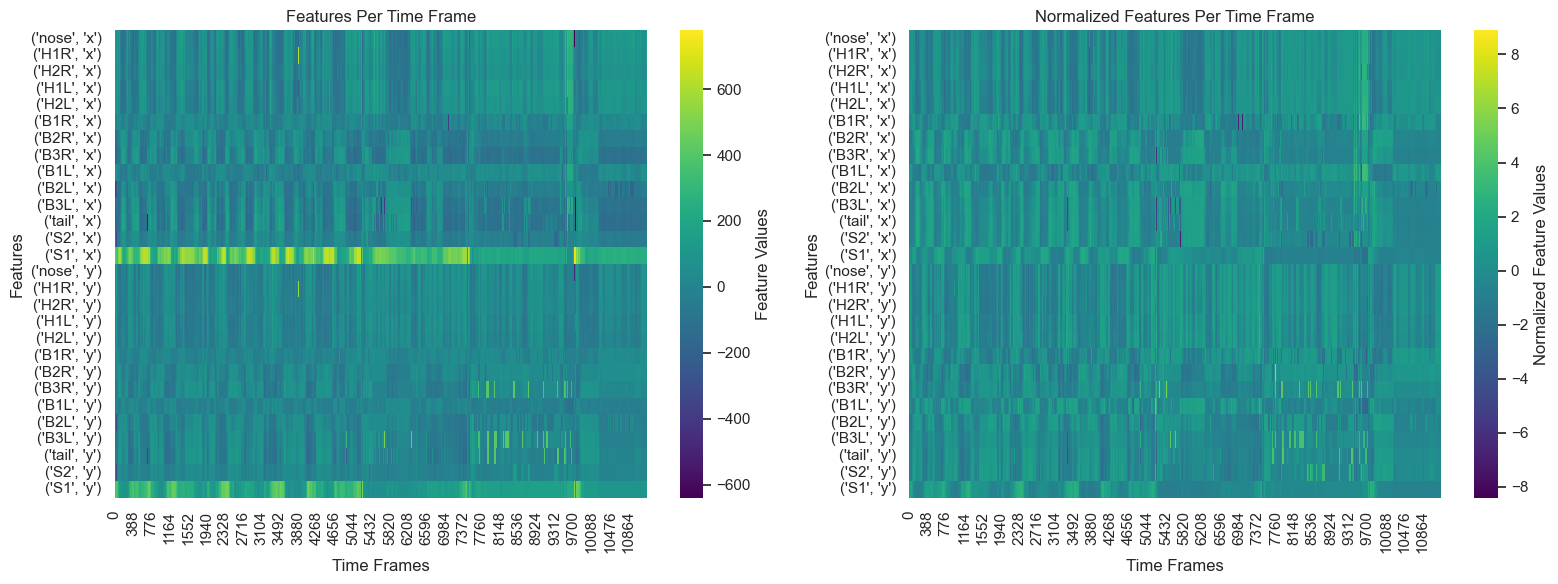

In [45]:
plot_dataframe_heatmap(dataset, datatype)

## Analysis
For analysis of the selected mouse data we have assembled a collection of methods that can be divided into being either spatial dimensionality reduction, temporal dimensionality reduction, or a combination of both. \
The methods can be divided into the mentioned categories as follows: \
**Spatial dimensionality reduction**:
- UMAP dimensionality reduction
- Trained RNN latent values

**Temporal dimensionality reduction**:
- HDBSCAN clustering
- GSBS State segmentation

This notebook explores 4 different (combinations of) methods on the mouse data to cluster behaviour. The following index shows the different methods and allows you to choose which to explore. \
Simply click on one of the method links to jump to that section of the notebook:
- [UMAP -> HDBSCAN](#UMAP-->-HDBSCAN)
- [RNN -> UMAP -> HDBSCAN](#RNN-->-UMAP-->-HDBSCAN)
- [GSBS](#GSBS)
- [RNN -> GSBS](#RNN-->-GSBS)

### UMAP -> HDBSCAN

#### Dimensionality reduction with UMAP
The following function will fit a UMAP dimensionality reduction model on the data. It will run an optimzation loop to try different parameters and find the best fit with them based on the silhouette score. \
It will also cluster the UMAP result using HDBSCAN, which can be limited by setting the `min_clusters` and `max_clusters` parameters as desired.

In [64]:
embedding_result, cluster_labels = fit_umap_and_hdbscan(dataset, min_clusters=10, max_clusters=40)

UMAP Parameter Grid Search: 100%|██████████████████████████████████████████████████████| 18/18 [11:54<00:00, 39.70s/it]

Best UMAP Parameters: {'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15}
Best HDBSCAN Parameters: {'min_cluster_size': 70, 'min_samples': 30}

Reconstruction error: 279.7518054006602
Silhouette score: 0.2144787311553955

Amount of clusters: 38


The reconstruction error is calculated by attempting to reconstruct the original data from the embedded UMAP result and measuring the Mean Squared Error between this reconstruction and the original data. \
The silhouette score is a measure of how well the individual data points fit in the cluster they were put in compared to the other clusters. The score ranges from -1 to 1, where a higher value means the data point is well matched in its cluster and poorly matched to other clusters. The mean of all data points' silhouette score is taken to calculate an overall silhouette coefficient.

#### Plotting UMAP and HDBSCAN cluster results
The function below will plot the UMAP and HDBSCAN cluster results. \
When using a 3-dimensional UMAP space, the function below will plot both a 3D plot of the results and a 2D plot of these results. Using a 2-dimensional UMAP will only plot a 2D result. \
The points in the UMAP scatter plots represent the original frames in the data but dimensionally reduced using UMAP. The coloured scatter plots show the same reduced data but with colours showing which cluster they were put in. \
The 'barcode' plots show a timeline of the video frames, using colours to show where each cluster's frames are located on the video timeline. \
**Note** that for the plots where we visualise clusters, we purposely leave out the noise cluster (denoted with a label of -1). This contains all data that HDBSCAN denotes as noise and does not deem fit in any cluster. \
Finally, we plot a heatmap showing the pairwise distances between the means of the clusters. This tells us which clusters are closer together than others and is useful for further analysis.

These plots show the data spatially reduced using UMAP:


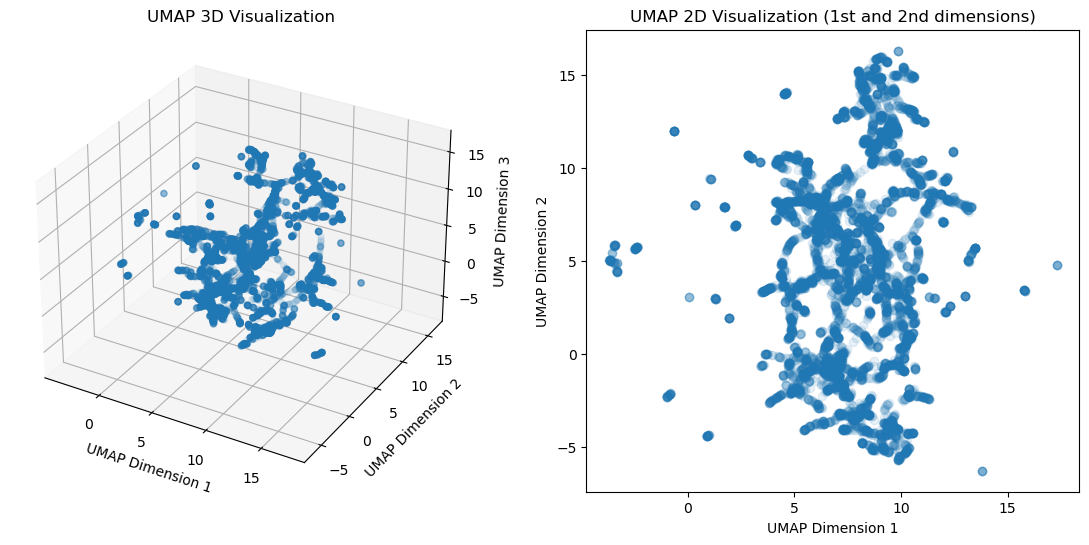

These plots show the same UMAP data but clustered using HDBSCAN:
Number of clusters (excluding noise): 37


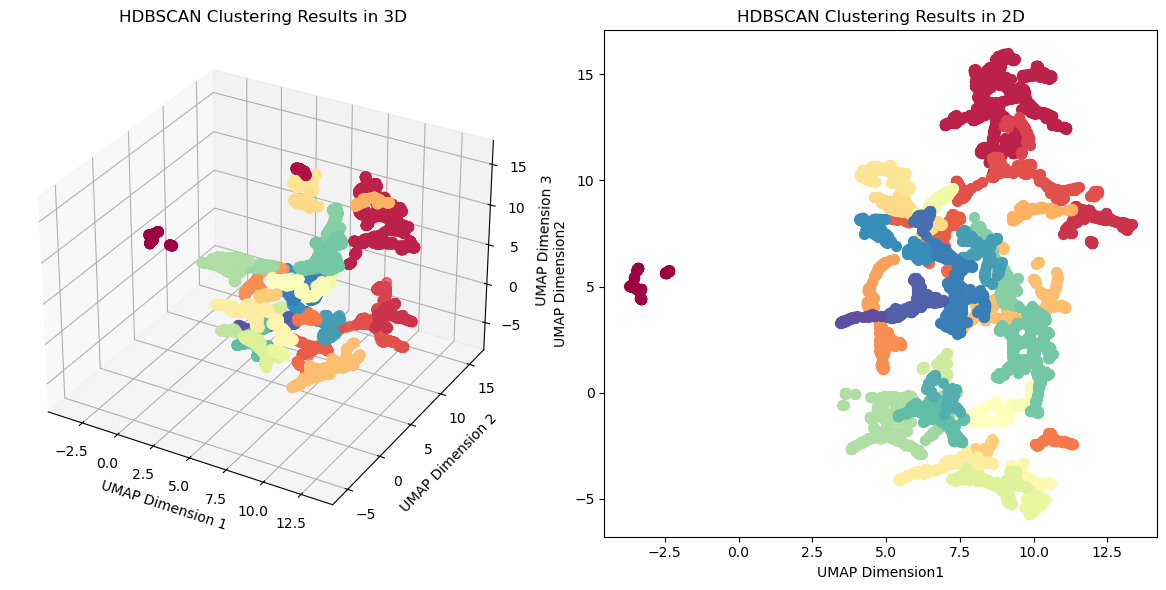

The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. 
The barcodes also show the freezing frames using black markers.
The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). 
- FRC is the percentage of frames within a cluster that are freezing frames. 
- CFC is the percentage of total freezing frames that belong to a specific cluster.


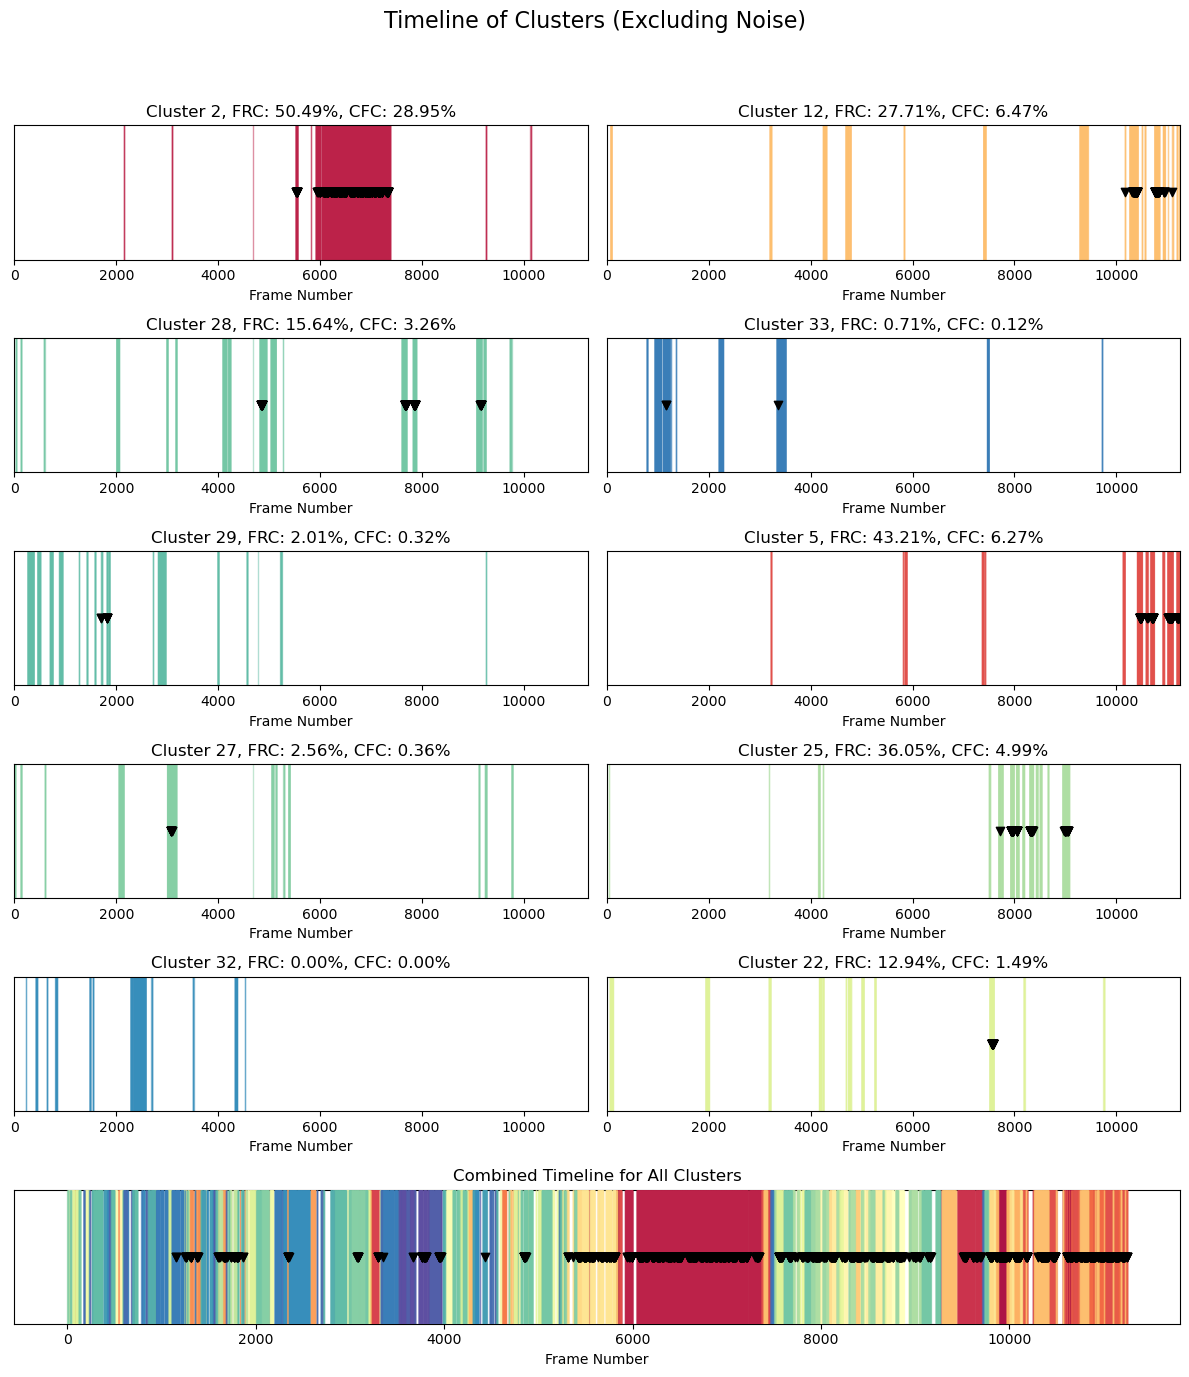

This plot shows a heatmap of the pairwise distances between cluster means:


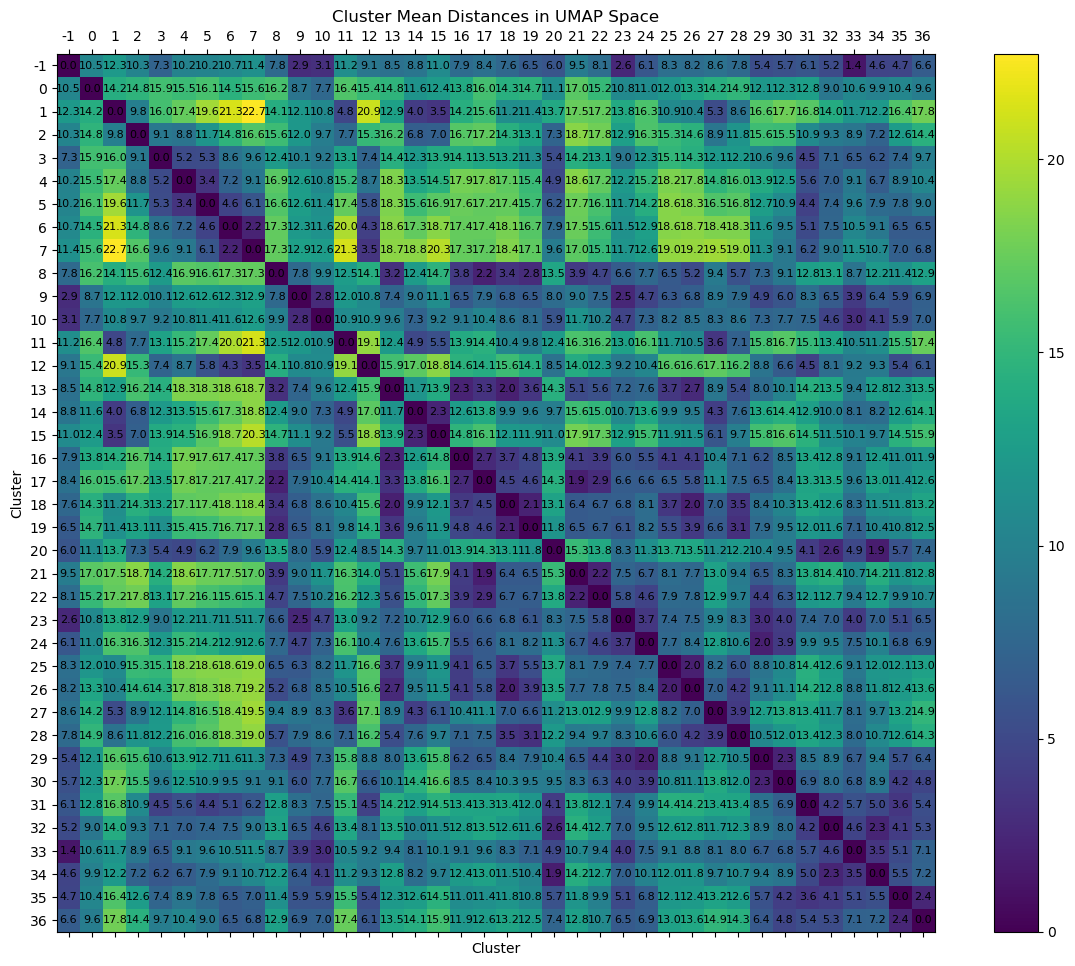

In [65]:
plot_umap_and_hdbscan_results(embedding_result, cluster_labels, dataset)

#### Visualising original video frames by cluster
The two cells below will allow you to choose a specific cluster and then visualise the video frames belonging to that cluster for you.

In [67]:
#### Run this cell! ####
cluster_options = np.unique(cluster_labels[cluster_labels != -1])
dropdown_cluster = widgets.Dropdown(options=cluster_options, description='Cluster:')
print("Which cluster would you like to see the video frames of?")
display(dropdown_cluster)

Which cluster would you like to see the video frames of?


Dropdown(description='Cluster:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

**Make sure to run the cell above to choose which cluster to view!**

In [69]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

cluster = dropdown_cluster.value
show_frames_for_cluster(input_video_path, cluster, dataset, cluster_labels)

#### Supervised UMAP results
The cell belows shows supervised UMAP results where the freezing frames are used as labels.

UMAP Parameter Grid Search: 100%|██████████████████████████████████████████████████████| 18/18 [17:06<00:00, 57.01s/it]


Best UMAP Parameters: {'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15}
Best HDBSCAN Parameters: {'min_cluster_size': 70, 'min_samples': 60}

Reconstruction error: 367.94285836221417
Silhouette score: 0.17446286976337433

Amount of clusters: 16
These plots show the data spatially reduced using UMAP:


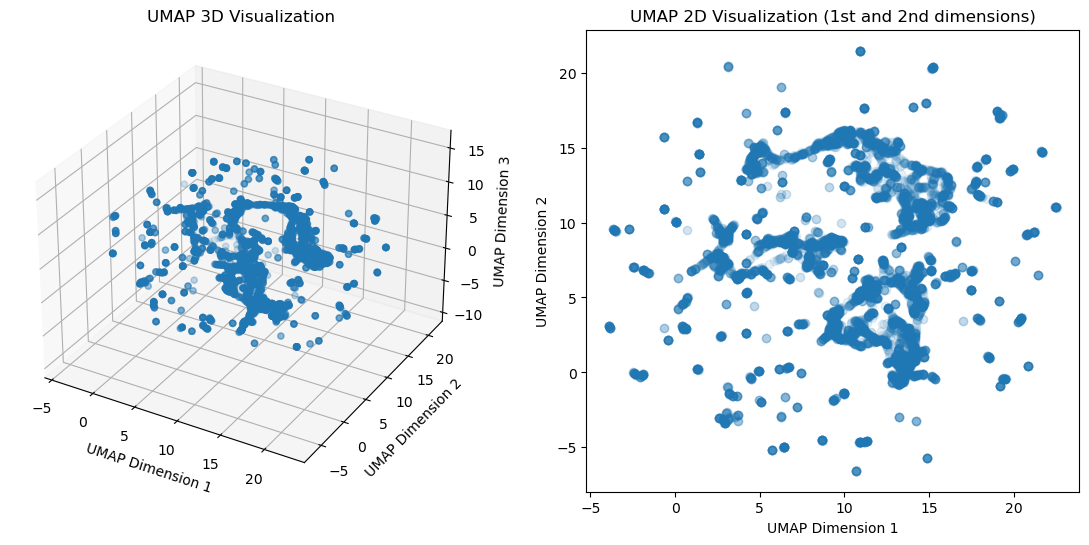

These plots show the same UMAP data but clustered using HDBSCAN:
Number of clusters (excluding noise): 15


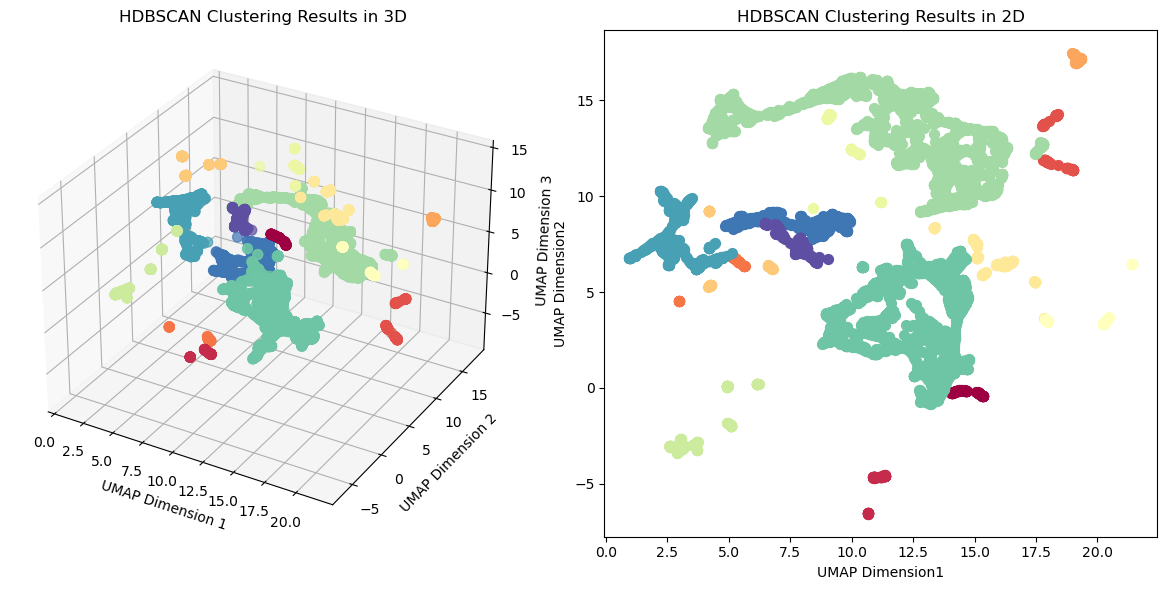

The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. 
The barcodes also show the freezing frames using black markers.
The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). 
- FRC is the percentage of frames within a cluster that are freezing frames. 
- CFC is the percentage of total freezing frames that belong to a specific cluster.


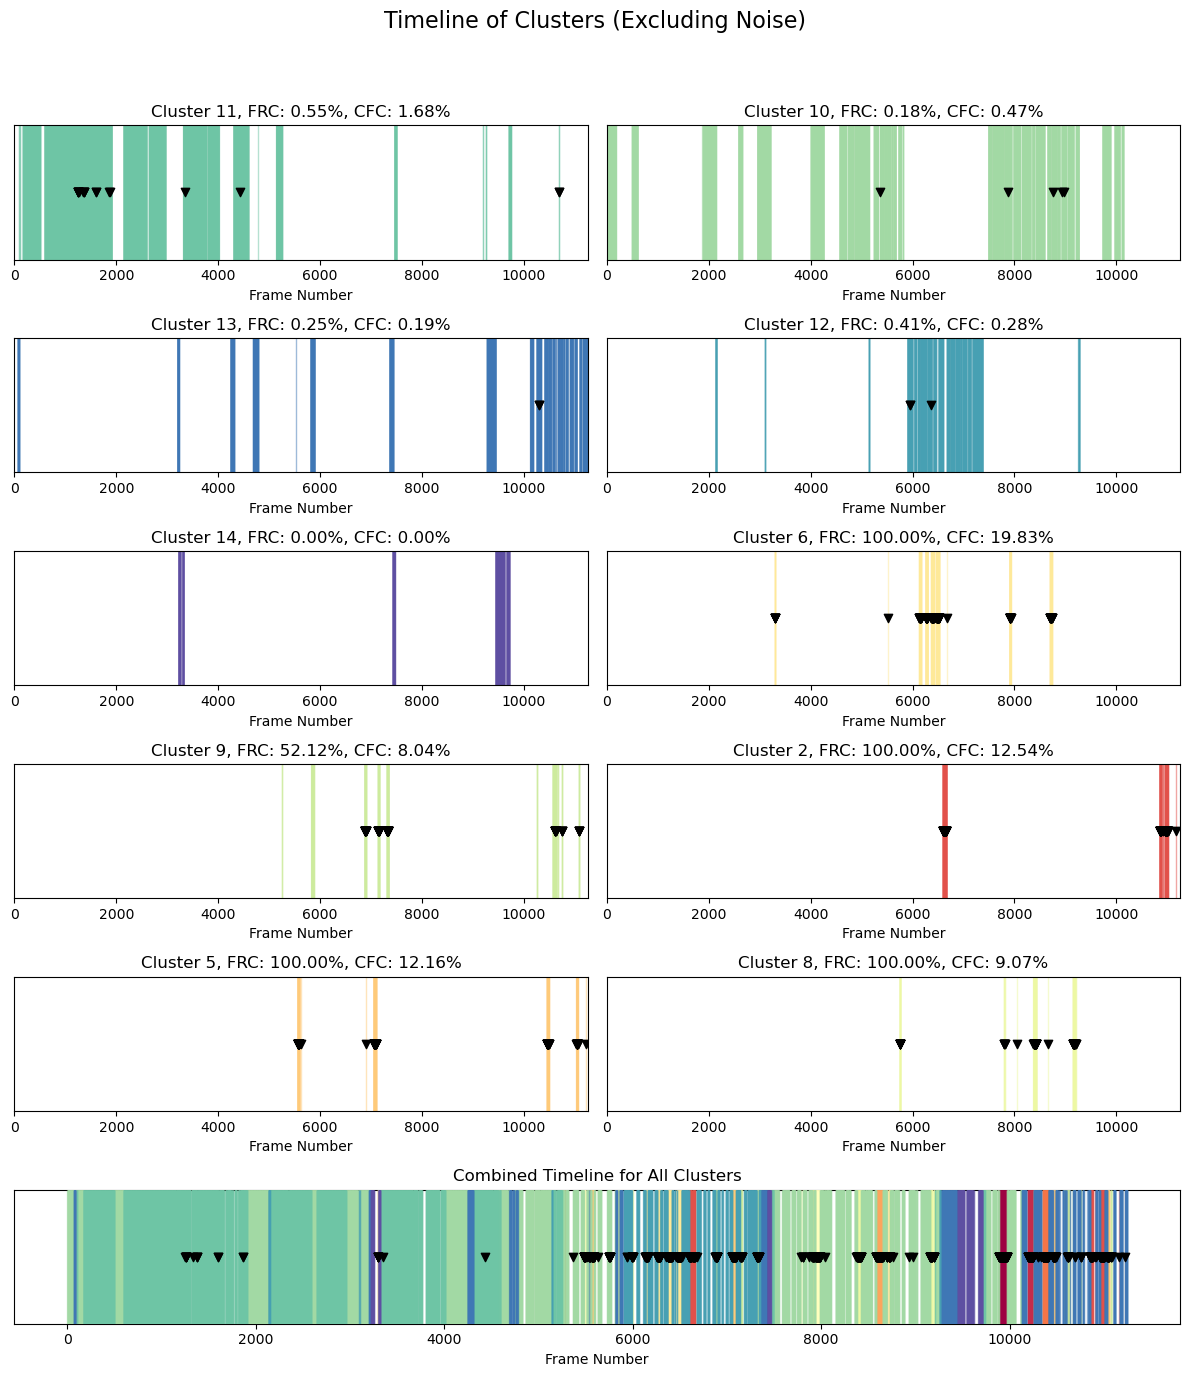

This plot shows a heatmap of the pairwise distances between cluster means:


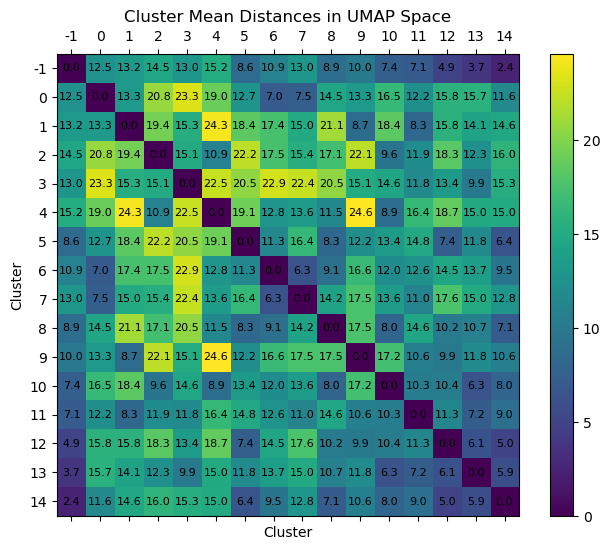

In [76]:
supervised_embedding_result, supervised_cluster_labels = fit_umap_and_hdbscan(dataset, min_clusters=10, max_clusters=40, supervised=True)
plot_umap_and_hdbscan_results(supervised_embedding_result, supervised_cluster_labels, dataset)

The two cells below will allow you to choose a specific cluster and then visualise the video frames belonging to that cluster for you.

In [77]:
#### Run this cell! ####
cluster_options = np.unique(supervised_cluster_labels[supervised_cluster_labels != -1])
dropdown_cluster = widgets.Dropdown(options=cluster_options, description='Cluster:')
print("Which cluster would you like to see the video frames of?")
display(dropdown_cluster)

Which cluster would you like to see the video frames of?


Dropdown(description='Cluster:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), value=0)

**Make sure to run the cell above to choose which cluster to view!**

In [ ]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

cluster = dropdown_cluster.value
show_frames_for_cluster(input_video_path, cluster, dataset, supervised_cluster_labels)

### RNN -> UMAP -> HDBSCAN

#### Training the RNN
The below functions will train an RNN model on the chosen dataset. \
The model will take 25 frames as input sequence, and attempt to predict the next 25 frames. \
The next input sequence is shifted by 25 frames from the last. \
You can view and/or change the model architecture in the code blocks below.

In [68]:
# This cell sets which device to use. If a GPU is available it will choose that, otherwise it will select CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [69]:
# Parameters for training the RNN
dropout_prob   = 0.5
epoch_num      = 10
hidden_size    = 16 # This defines the size of the latent values
layer_num      = 2
learning_rate  = 1e-3
seq_size       = 25 # The amount of frames inputted as one sequence, 25 frames is 1 second of video
pred_window    = 25 # The amount of frames (after the input) the model predicts, 25 frames is 1 second of video
shift_size     = 25 # By how many frames each new input for the model is shifted
batch_size     = 64 # The batch size for the dataloaders

# This function processes the data, splits it into train, test, and validation, normalizes it, and creates DataLoaders
data_loader = preprocess_data(dataset, seq_size, pred_window, shift_size, batch_size, device)

In [70]:
# Get the input and output size of our data
input_size = next(iter(data_loader))[0][:, :, 1:-2].size(-1)
output_size = next(iter(data_loader))[1][:, :, 1:-2].size(-1)

# Create our model with our parameters and data sizes
model = Model(dropout_prob, hidden_size, layer_num, input_size, output_size).to(device)

# Create a loss function and optimizer for the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
print(model)

Model(
  (gru): GRU(28, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)


In [55]:
# Set a save location for the model (including filename for the model)
mouse_no = dataset['mouse_no'].unique().item()
save_dir = f"../Models/rnn_{datatype}_data_1l_mouse_nr_{str(mouse_no)}_hidden_size_{str(hidden_size)}.pt"

train_model(model, epoch_num, optimizer, criterion, data_loader, save_dir)

Epoch 0/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.59it/s]


Train loss: 1.0305


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 27.18it/s]


Train loss: 1.0166


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 26.84it/s]


Train loss: 1.0041


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.97it/s]


Train loss: 0.9935


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.55it/s]


Train loss: 0.9850


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.99it/s]


Train loss: 0.9758


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.68it/s]


Train loss: 0.9665


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.61it/s]


Train loss: 0.9595


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.23it/s]


Train loss: 0.9533


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.90it/s]

Train loss: 0.9460


#### Extract latent values
The below functions will load in the saved model and run the full dataset through it. \
Instead of the final predictions, we collect the intermediate layer outputs also called the latent space. This intermediate layer encodes information about the input and is a lower dimensional representation of it that captures essential features or patterns.\
We use an RNN which learns sequences of data. Ideally, the latent space of such a model will capture meaningful sequences or behaviours from the data.

In [71]:
# Load the saved model
# model.load_state_dict(torch.load(save_dir))
model.load_state_dict(torch.load("../Models/rnn_MouseDirectional_data_1l_mouse_nr_2.4_hidden_size_16.pt"))
model.eval()

Model(
  (gru): GRU(28, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)

In [72]:
# Analyses the model using the test data, and obtains the performance (loss) and latent values for all sequences
latents_df = extract_latents(model, data_loader, criterion)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.80it/s]


#### Dimensionality reduction
In order to visualise and cluster the latent space properly, we have to reduce the amount of dimensions further. \
We can do this using PCA, UMAP, or by setting the `hidden_size` variable of the RNN to 3. This last one ensures that the latent dimensions of the RNN are already small enough to cluster directly.

In [73]:
#### Run this cell! ####
dim_red_options = ['PCA', 'UMAP', 'RNN']
dropdown2 = widgets.Dropdown(options=dim_red_options, description='Dimensionality reduction:')
print("What type of dimensionality reduction would you like to work with?")
display(dropdown2)

What type of dimensionality reduction would you like to work with?


Dropdown(description='Dimensionality reduction:', options=('PCA', 'UMAP', 'RNN'), value='PCA')

**Make sure to run the cell above to be able to choose the dimensionality reduction method!** \
To use solely the RNN model as the dimensionality reduction method, instead of combining the RNN with PCA or UMAP as dimensionality reduciton, ensure that the `hidden_size` variable is set to `3`.

In [74]:
dim_red_type = dropdown2.value

min_clusters = 10
max_clusters = 40

if dim_red_type == 'UMAP':
    embedding_result, cluster_labels = fit_umap_and_hdbscan(latents_df, min_clusters, max_clusters)
elif dim_red_type == 'PCA':
    embedding_result, cluster_labels = fit_pca_and_hdbscan(latents_df, min_clusters, max_clusters)
elif dim_red_type == 'RNN':
    cluster_labels = fit_hdbscan(latents_df, min_clusters, max_clusters)

UMAP Parameter Grid Search: 100%|██████████████████████████████████████████████████████| 18/18 [10:05<00:00, 33.63s/it]

Best UMAP Parameters: {'min_dist': 0.5, 'n_components': 2, 'n_neighbors': 10}
Best HDBSCAN Parameters: {'min_cluster_size': 30, 'min_samples': 20}

Reconstruction error: 0.010364357382059097
Silhouette score: -0.20105063915252686

Amount of clusters: 10


The reconstruction error is calculated by attempting to reconstruct the original data from the embedded result and measuring the Mean Squared Error between this reconstruction and the original data. \
The silhouette score is a measure of how well the individual data points fit in the cluster they were put in compared to the other clusters. The score ranges from -1 to 1, where a higher value means the data point is well matched in its cluster and poorly matched to other clusters. The mean of all data points' silhouette score is taken to calculate an overall silhouette coefficient.

#### Plotting dimensionality reduction and HDBSCAN cluster results
The function below will plot the UMAP and HDBSCAN cluster results. \
When using a 3-dimensional UMAP space, the function below will plot both a 3D plot of the results and a 2D plot of these results. Using a 2-dimensional UMAP will only plot a 2D result. \
The points in the UMAP scatter plots represent the original frames in the data but dimensionally reduced using UMAP. The coloured scatter plots show the same reduced data but with colours showing which cluster they were put in. \
The 'barcode' plots show a timeline of the video frames, using colours to show where each cluster's frames are located on the video timeline. \
**Note** that for the plots where we visualise clusters, we purposely leave out the noise cluster (denoted with a label of -1). This contains all data that HDBSCAN denotes as noise and does not deem fit in any cluster. \
Finally, we plot a heatmap showing the pairwise distances between the means of the clusters. This tells us which clusters are closer together than others and is useful for further analysis.

These plots show the data spatially reduced using UMAP:


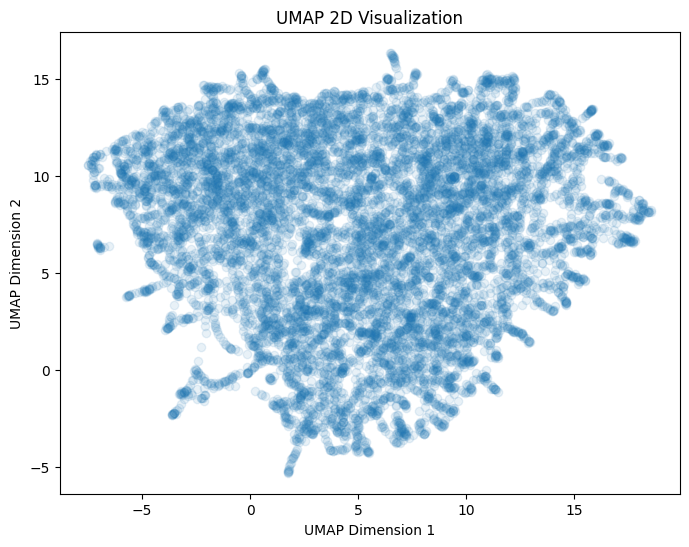

These plots show the same UMAP data but clustered using HDBSCAN:
Number of clusters (excluding noise): 9


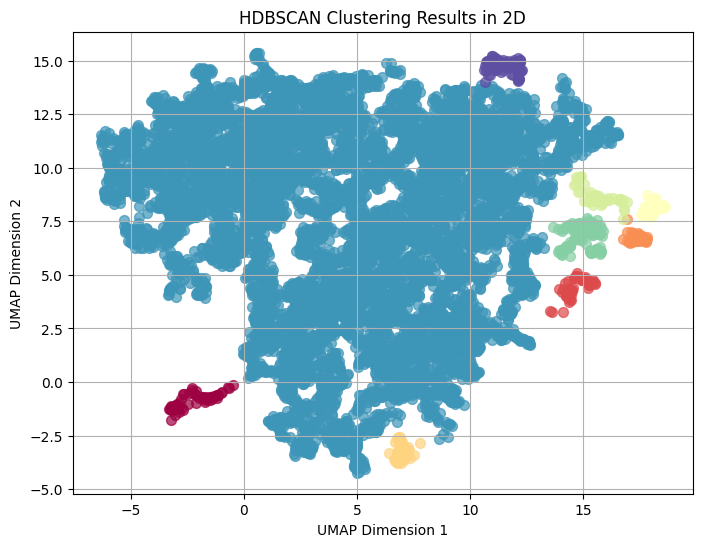

The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. 
The barcodes also show the freezing frames using black markers.
The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). 
- FRC is the percentage of frames within a cluster that are freezing frames. 
- CFC is the percentage of total freezing frames that belong to a specific cluster.


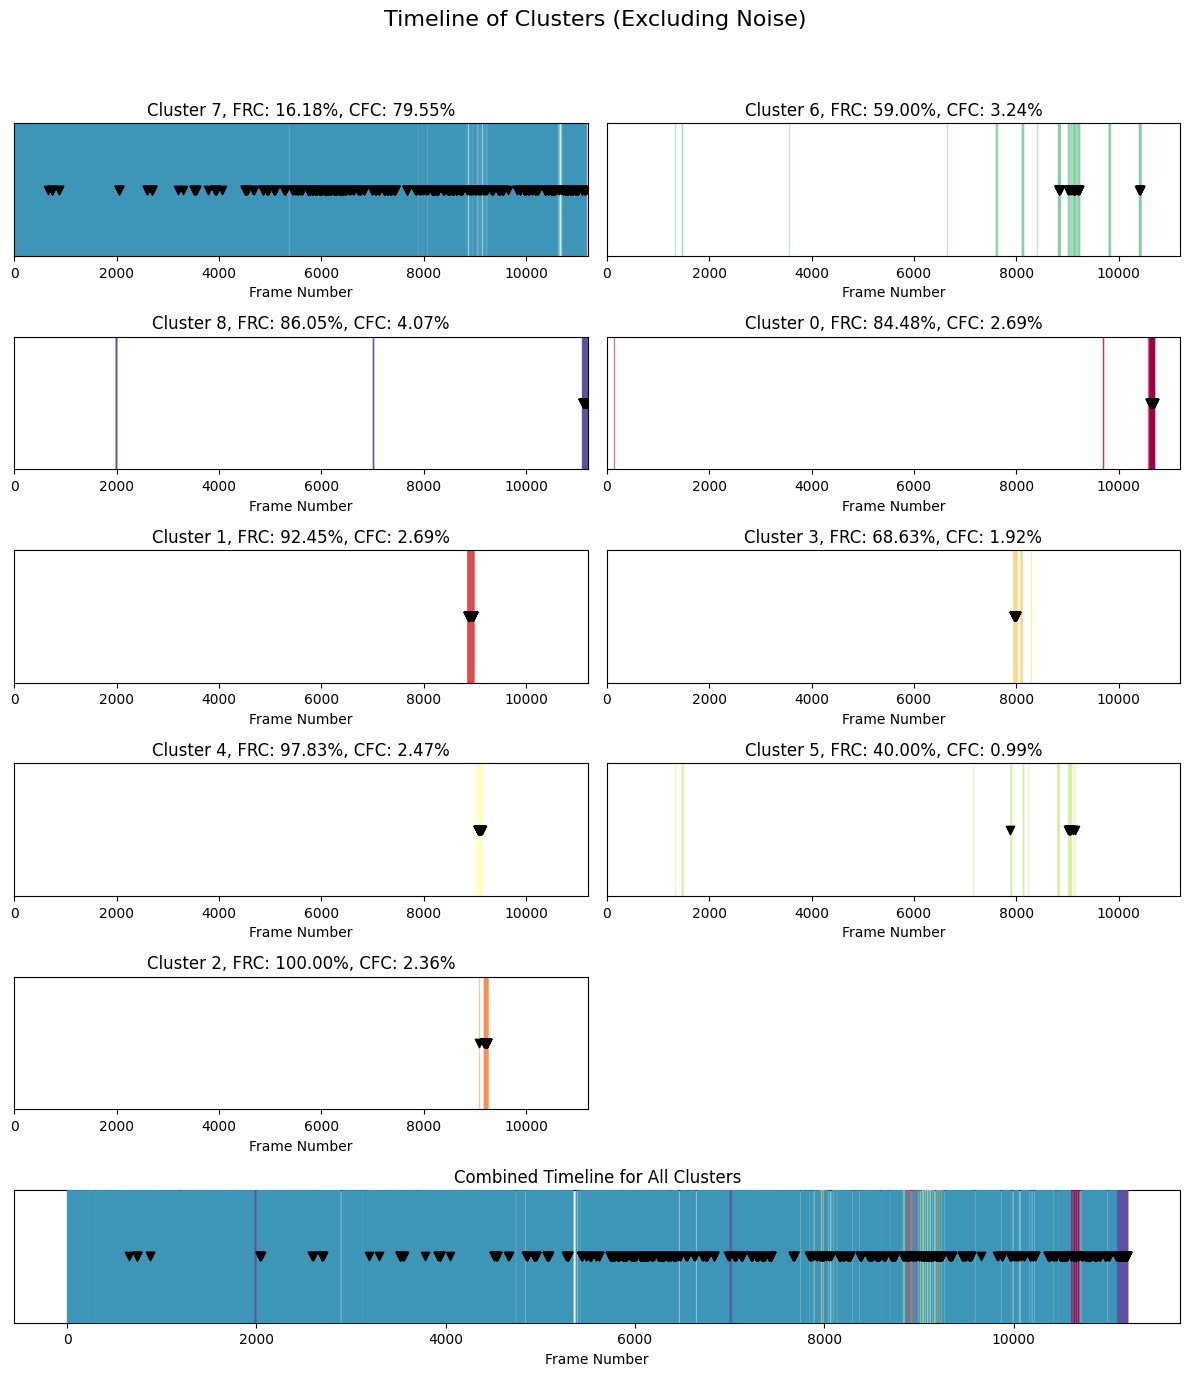

This plot shows a heatmap of the pairwise distances between cluster means:


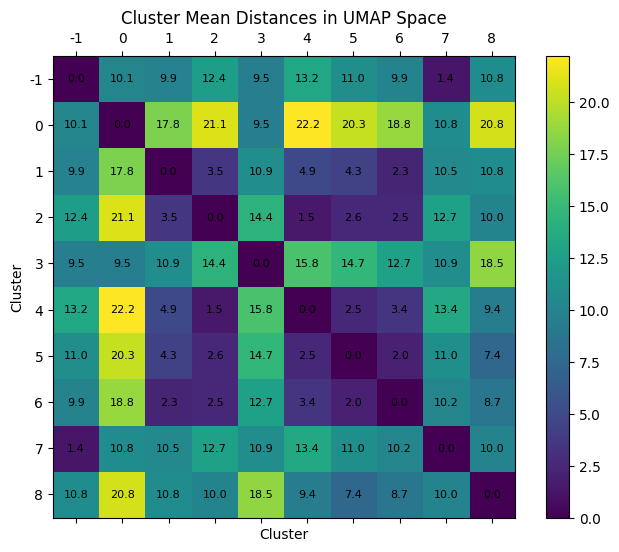

In [75]:
if dim_red_type == 'UMAP':
    plot_umap_and_hdbscan_results(embedding_result, cluster_labels, dataset)
elif dim_red_type == 'PCA':
    plot_pca_and_hdbscan_results(embedding_result, cluster_labels, dataset)
elif dim_red_type == 'RNN':
    plot_rnn_and_hdbscan_results(latents_df, cluster_labels, dataset)

#### Visualising original video frames by cluster
The two cells below will allow you to choose a specific cluster and then visualise the video frames belonging to that cluster for you.

In [76]:
#### Run this cell! ####
cluster_options = np.unique(cluster_labels[cluster_labels != -1])
dropdown_cluster = widgets.Dropdown(options=cluster_options, description='Cluster:')
print("Which cluster would you like to see the video frames of?")
display(dropdown_cluster)

Which cluster would you like to see the video frames of?


C:\Users\Kieran\anaconda3\lib\site-packages\traitlets\traitlets.py:711: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  silent = bool(old_value == new_value)


Dropdown(description='Cluster:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8), value=0)

**Make sure to run the cell above to choose which cluster to view!**

In [ ]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

cluster = dropdown_cluster.value
show_frames_for_cluster(input_video_path, cluster, dataset, cluster_labels)

#### Supervised UMAP results
The cell belows shows supervised UMAP results where the freezing frames are used as labels.

UMAP Parameter Grid Search: 100%|██████████████████████████████████████████████████████| 18/18 [19:00<00:00, 63.34s/it]


Best UMAP Parameters: {'min_dist': 0.1, 'n_components': 3, 'n_neighbors': 15}
Best HDBSCAN Parameters: {'min_cluster_size': 30, 'min_samples': 70}

Reconstruction error: 0.007823038846254349
Silhouette score: 0.41637182235717773

Amount of clusters: 15
These plots show the data spatially reduced using UMAP:


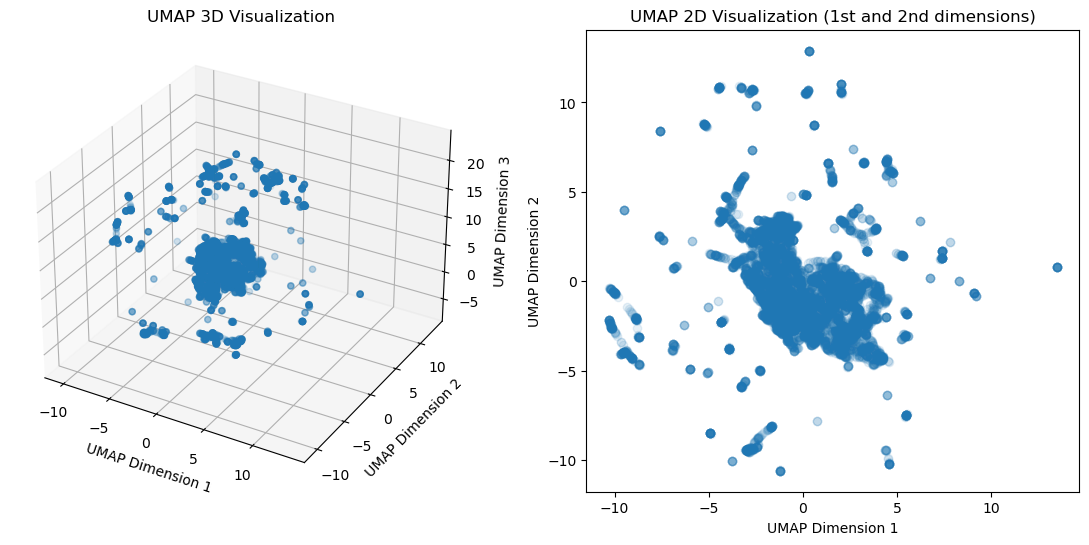

These plots show the same UMAP data but clustered using HDBSCAN:
Number of clusters (excluding noise): 14


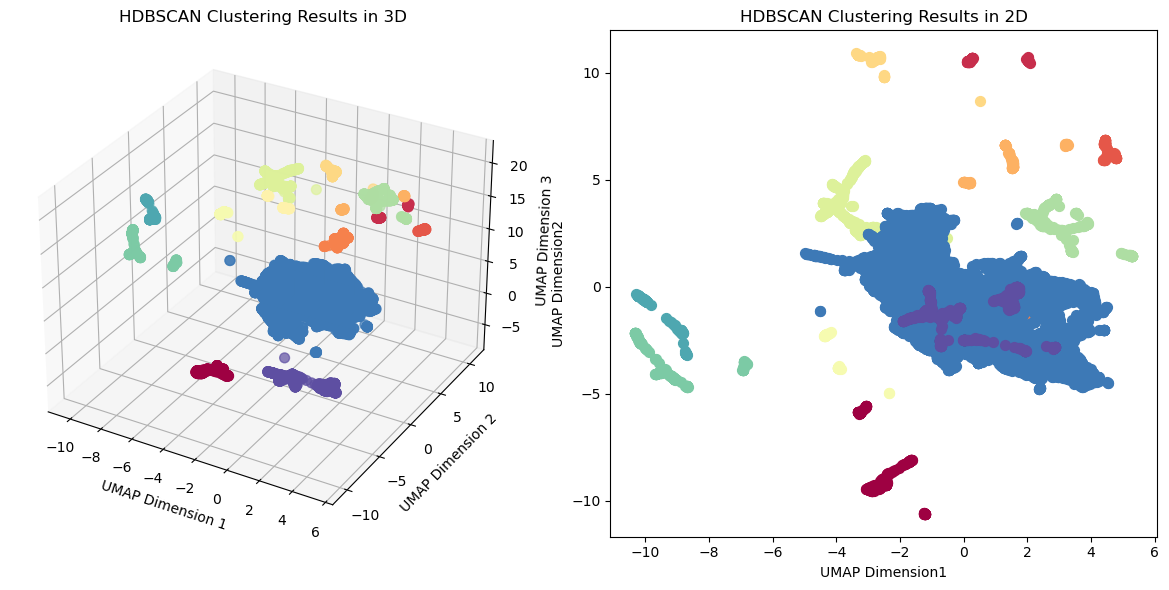

The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. 
The barcodes also show the freezing frames using black markers.
The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). 
- FRC is the percentage of frames within a cluster that are freezing frames. 
- CFC is the percentage of total freezing frames that belong to a specific cluster.


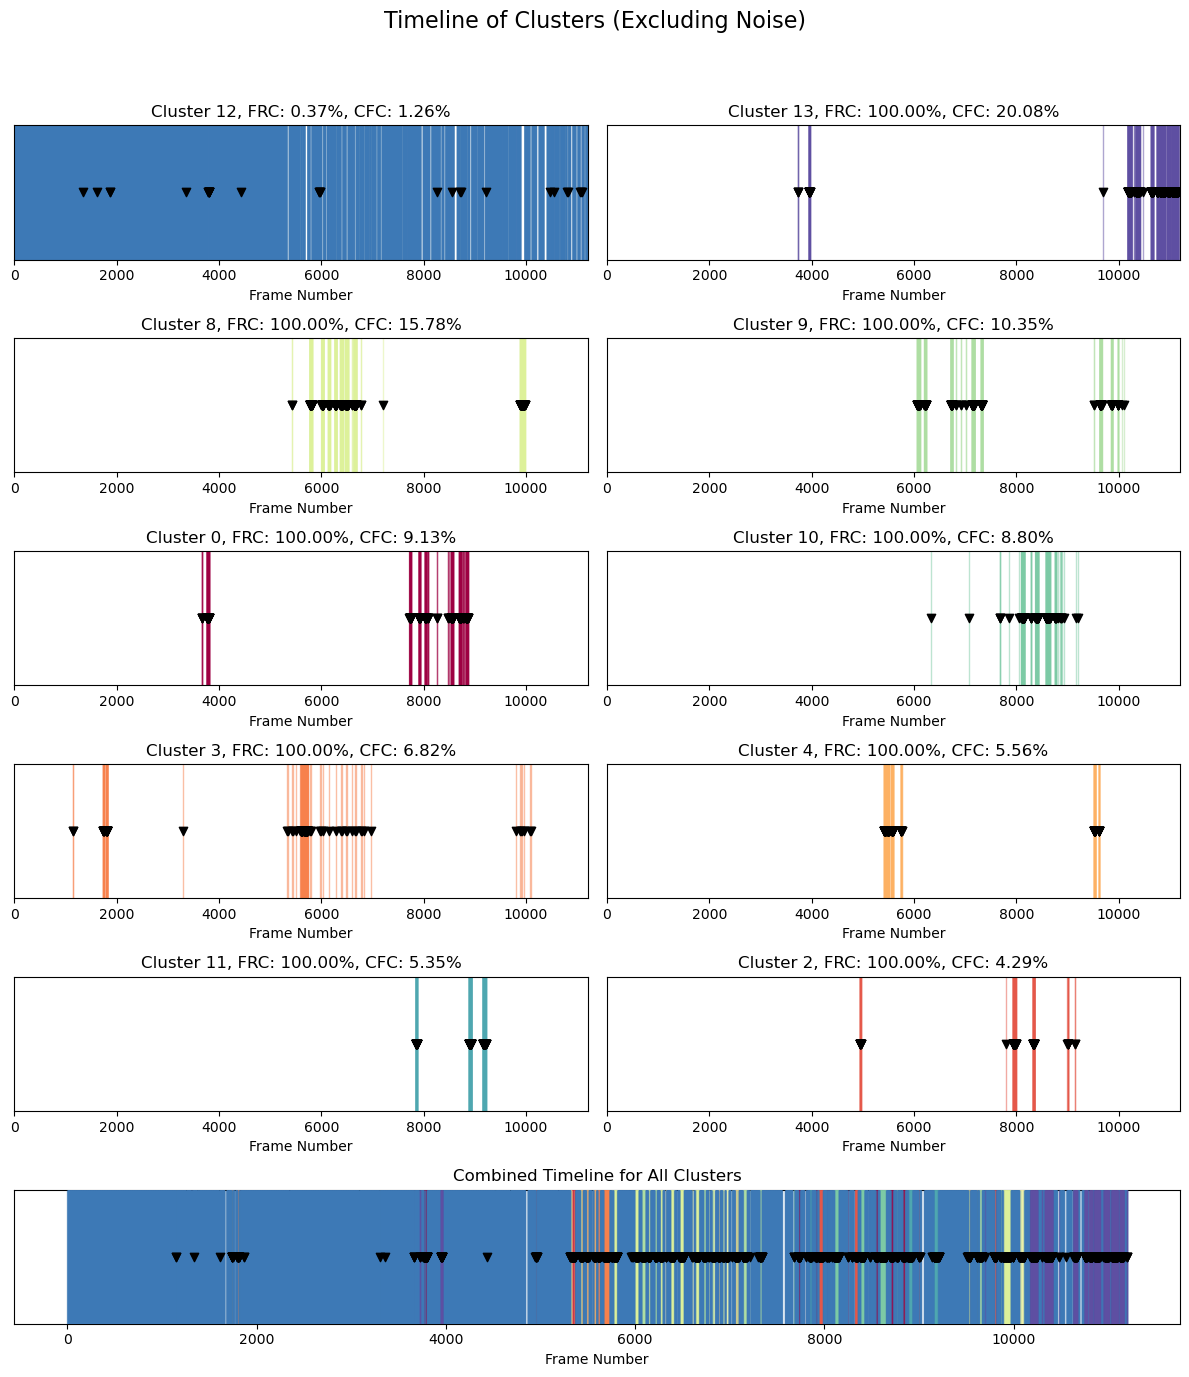

This plot shows a heatmap of the pairwise distances between cluster means:


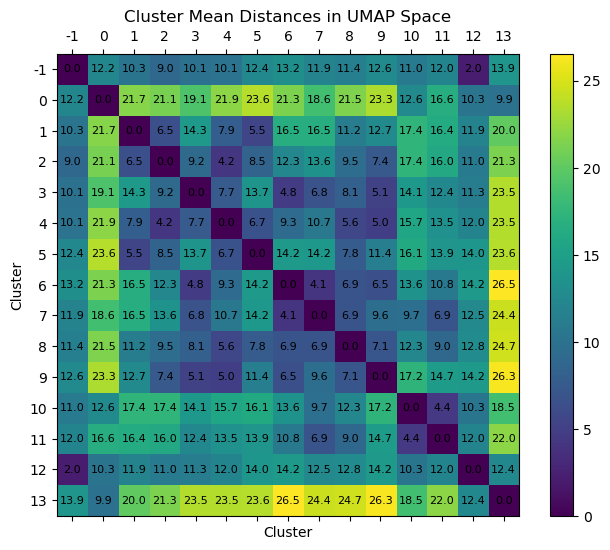

In [96]:
supervised_embedding_result, supervised_cluster_labels = fit_umap_and_hdbscan(latents_df, min_clusters=10, max_clusters=40, supervised=True)
plot_umap_and_hdbscan_results(supervised_embedding_result, supervised_cluster_labels, dataset)

The two cells below will allow you to choose a specific cluster and then visualise the video frames belonging to that cluster for you.

In [98]:
joblib.dump(supervised_embedding_result, "../Results/Mouse 5.4/RNN_supervised_embedding_result.joblib")
joblib.dump(supervised_cluster_labels, "../Results/Mouse 5.4/RNN_supervised_cluster_labels.joblib")
joblib.dump(embedding_result, "../Results/Mouse 5.4/RNN_embedding_result.joblib")
joblib.dump(cluster_labels, "../Results/Mouse 5.4/RNN_cluster_labels.joblib")

['../Results/Mouse 5.4/RNN_cluster_labels.joblib']

In [62]:
#### Run this cell! ####
cluster_options = np.unique(cluster_labels[cluster_labels != -1])
dropdown_cluster = widgets.Dropdown(options=cluster_options, description='Cluster:')
print("Which cluster would you like to see the video frames of?")
display(dropdown_cluster)

Which cluster would you like to see the video frames of?


Dropdown(description='Cluster:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

**Make sure to run the cell above to choose which cluster to view!**

In [ ]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

cluster = dropdown_cluster.value
show_frames_for_cluster(input_video_path, cluster, dataset, cluster_labels)

### GSBS
The greedy state boundary search (GSBS) method relies on a simple greedy search algorithm to identify the location of state boundaries. The method searches for transitions between states, but is not designed to identify recurring states. State boundaries are identified in an iterative fashion.

#### Downsampling the data
This cell will downsample the data in time so that GSBS can be (feasibly) fit on it.

In [246]:
step_size = 20 # step_size denotes how many frames to skip over in order to downsample
downsampled_data, time_series = downsample_data(dataset, step_size)
print(f"Downsampled to {len(time_series)} frames.")

Downsampled to 564 frames.


#### Correlation matrix of the downsampled data

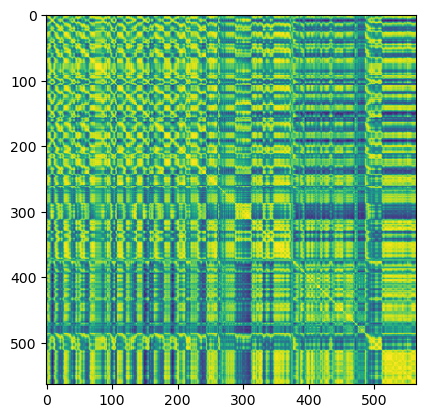

In [247]:
corr = np.corrcoef(time_series)
plt.imshow(corr)
plt.show()

#### Fitting the GSBS model

In [248]:
GSBS_model = GSBS(x=time_series, kmax=int(len(time_series) * 0.5), statewise_detection=True)
GSBS_model.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [02:31<00:00,  1.85it/s]


#### Analysis plots

This plot shows the correlation matrix of the data with the segmented states overlaid in red.


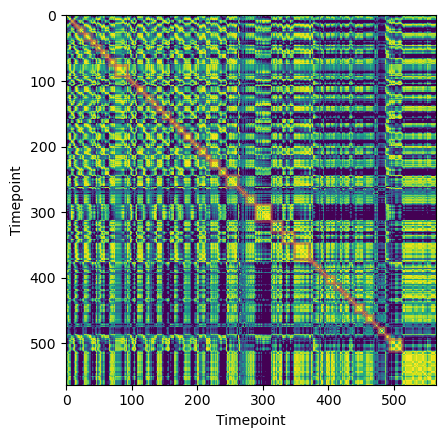

These plots show the measure of fit (left) and the state transitions over time (right).
Note that we purposely use the best fit after a minimum of 10 boundaries in order to ensure we have some meaningful states.


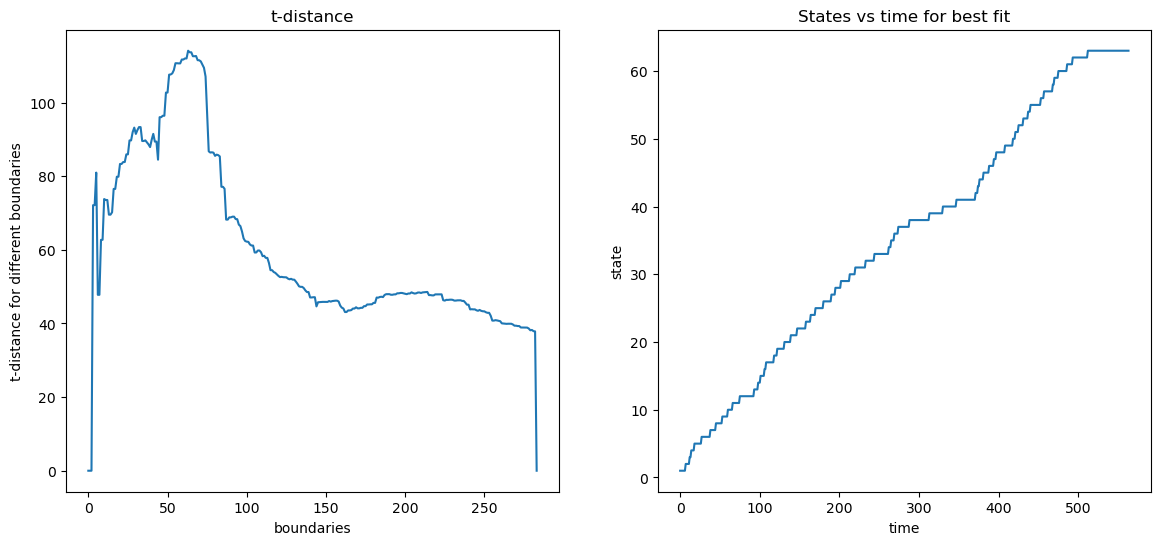

This plot shows a histogram of pattern correlations. This visualises the correlation between the segmented states, which is the measure we will next use to combine separate states.


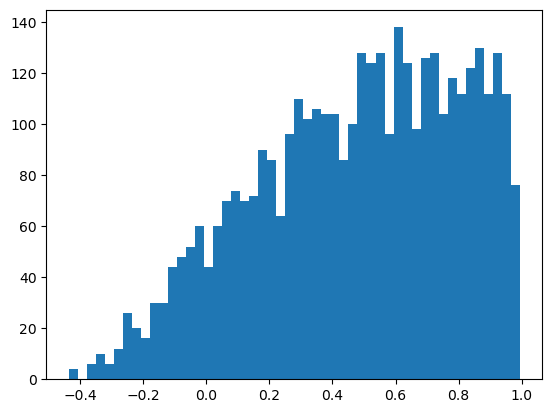

In [249]:
plot_gsbs_results(GSBS_model, time_series)

#### Finding unique states

The following cell will go through the GSBS segmented states and reduce them to a unique set of states.\
It does this by comparing the states using their correlation and merging states that have a correlation higher than the given threshold.

In [257]:
# You can alter the threshold value to change the resulting number of unique states
merged_states = merge_similar_states(GSBS_model, threshold=0.9)

Reduced the number of unique states from 63 to 23


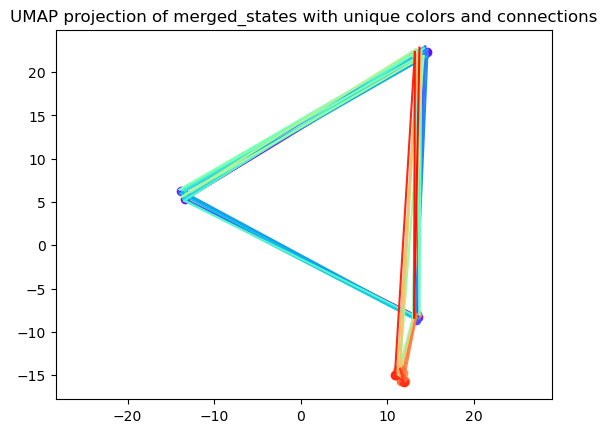

In [259]:
# Initialize and fit UMAP
reducer = UMAP(n_components=2)
embedding = reducer.fit_transform(merged_states)

# Plotting
unique_states = set()
colors = plt.cm.rainbow(np.linspace(0, 1, len(merged_states)))

for i in range(len(merged_states)):
    state = tuple(merged_states[i])  # Convert to tuple to make it hashable
    if state not in unique_states:
        plt.scatter(embedding[i, 0], embedding[i, 1], color=colors[i])
        unique_states.add(state)
    if i < len(merged_states) - 1:
        plt.plot(embedding[i:i+2, 0], embedding[i:i+2, 1], color=colors[i])  # Connect with lines

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of merged_states with unique colors and connections')
plt.show()

The next function will print the start and ending frame for all instances of each unique state. \
This helps us to easier analyse and find the states/behaviours in the original video data. \
This function also 'upsamples' the data using the labelled downsampled data. \
It takes the state labels from the downsampled data and inserts them into the original sized dataset. It then fills in the missing values based on the nearest state label. \
By doing this, we ensure that we have state labels for the full frame dataset and not just for the time-downsampled frames.

In [260]:
state_data, state_labels, labelled_dataset = print_frames_per_state(downsampled_data, dataset, GSBS_model, merged_states)

Sequences for state '12.0': 
Start frame: 0, end frame: 130
Start frame: 531, end frame: 750
Start frame: 1311, end frame: 1490
Start frame: 1851, end frame: 1950
Start frame: 2151, end frame: 2350
Start frame: 2771, end frame: 2930
Start frame: 3271, end frame: 3390
Start frame: 4391, end frame: 4650
Start frame: 4871, end frame: 5230
Start frame: 5471, end frame: 5750
Start frame: 6251, end frame: 6590
Start frame: 6931, end frame: 7410
Start frame: 7471, end frame: 7510
Start frame: 10231, end frame: 11249

Sequences for state '0.0': 
Start frame: 131, end frame: 230
Start frame: 2611, end frame: 2770
Start frame: 2931, end frame: 3150
Start frame: 3791, end frame: 3890

Sequences for state '5.0': 
Start frame: 231, end frame: 270
Start frame: 1491, end frame: 1850
Start frame: 2011, end frame: 2110
Start frame: 2431, end frame: 2610
Start frame: 3891, end frame: 4030
Start frame: 4251, end frame: 4390
Start frame: 9851, end frame: 10230

Sequences for state '7.0': 
Start frame: 271

The following plots show the sequence of states and what these states look like over time(frames)

This plot shows states by colour, showing their order and recurrence throughout the data:


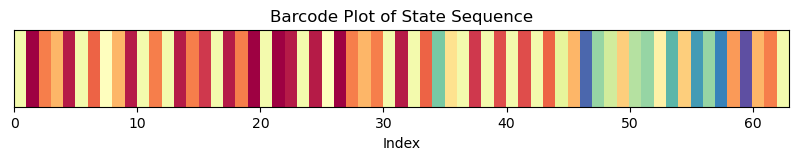

This plot shows the states over the frames and includes markers to show the freezing frames:


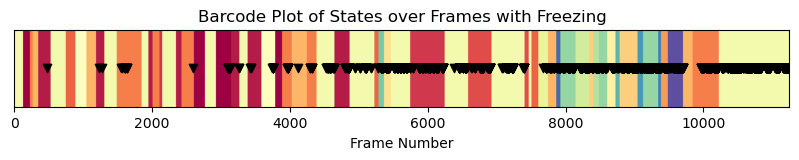

In [261]:
plot_barcodes(merged_states, labelled_dataset)

#### Visualising original video frames by state
The two cells below will allow you to choose a specific state and then visualise the video frames belonging to that state for you.

In [262]:
#### Run this cell! ####
state_options = np.unique(state_labels)
dropdown_state = widgets.Dropdown(options=state_options, description='State:')
print("Which state would you like to see the video frames of?")
display(dropdown_state)

Which state would you like to see the video frames of?


Dropdown(description='State:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

**Make sure to run the cell above to choose which state to view!**

In [ ]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

state = dropdown_state.value
state_labels = downsampled_data['state_label']
show_frames_for_cluster(input_video_path, state, downsampled_data, state_labels)

### RNN -> GSBS

#### Training the RNN
The below functions will train an RNN model on the chosen dataset. \
The model will take 25 frames as input sequence, and attempt to predict the next 25 frames. \
The next input sequence is shifted by 25 frames from the last. \
You can view and/or change the model architecture in the code blocks below.

In [46]:
# This cell sets which device to use. If a GPU is available it will choose that, otherwise it will select CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [47]:
# Parameters for training the RNN
dropout_prob   = 0.5
epoch_num      = 10
hidden_size    = 16 # This defines the size of the latent values
layer_num      = 2
learning_rate  = 1e-3
seq_size       = 25 # The amount of frames inputted as one sequence, 25 frames is 1 second of video
pred_window    = 25 # The amount of frames (after the input) the model predicts, 25 frames is 1 second of video
shift_size     = 25 # By how many frames each new input for the model is shifted
batch_size     = 64 # The batch size for the dataloaders

# This function processes the data, splits it into train, test, and validation, normalizes it, and creates DataLoaders
data_loader = preprocess_data(dataset, seq_size, pred_window, shift_size, batch_size, device)

In [48]:
# Get the input and output size of our data
input_size = next(iter(data_loader))[0][:, :, 1:-2].size(-1)
output_size = next(iter(data_loader))[1][:, :, 1:-2].size(-1)

# Create our model with our parameters and data sizes
model = Model(dropout_prob, hidden_size, layer_num, input_size, output_size).to(device)

# Create a loss function and optimizer for the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
print(model)

Model(
  (gru): GRU(28, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)


In [267]:
# Set a save location for the model (including filename for the model)
mouse_no = dataset['mouse_no'].unique().item()
save_dir = f"../Models/rnn_{datatype}_data_1l_mouse_nr_{str(mouse_no)}_hidden_size_{str(hidden_size)}.pt"

train_model(model, epoch_num, optimizer, criterion, data_loader, save_dir)

Epoch 0/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 46.37it/s]


Train loss: 1.0123


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 47.78it/s]


Train loss: 0.9768


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.09it/s]


Train loss: 0.9475


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.84it/s]


Train loss: 0.9203


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 45.66it/s]


Train loss: 0.8948


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 50.01it/s]


Train loss: 0.8688


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.42it/s]


Train loss: 0.8433


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.40it/s]


Train loss: 0.8192


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 51.79it/s]


Train loss: 0.7953


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 42.34it/s]

Train loss: 0.7756


#### Extract latent values
The below functions will load in the saved model and run the full dataset through it. \
Instead of the final predictions, we collect the intermediate layer outputs also called the latent space. This intermediate layer encodes information about the input and is a lower dimensional representation of it that captures essential features or patterns.\
We use an RNN which learns sequences of data. Ideally, the latent space of such a model will capture meaningful sequences or behaviours from the data.

In [49]:
# Load the saved model
# model.load_state_dict(torch.load(save_dir))
model.load_state_dict(torch.load("../Models/rnn_MouseCentric_data_1l_mouse_nr_11.4_hidden_size_16.pt"))
model.eval()

Model(
  (gru): GRU(28, 16, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=16, out_features=28, bias=True)
)

In [50]:
# Analyses the model using the test data, and obtains the performance (loss) and latent values for all sequences
latents_df = extract_latents(model, data_loader, criterion)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 43.49it/s]


#### Downsampling the data
This cell will downsample the data in time so that GSBS can be (feasibly) fit on it.

In [51]:
step_size = 20 # step_size denotes how many frames to skip over in order to downsample
downsampled_data, time_series = downsample_data(latents_df, step_size)
print(f"Downsampled to {len(time_series)} frames.")

Downsampled to 561 frames.


#### Correlation matrix of the downsampled data

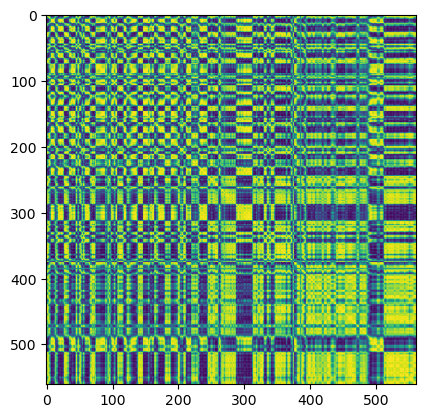

In [52]:
corr = np.corrcoef(time_series)
plt.imshow(corr)
plt.show()

#### Fitting the GSBS model

In [53]:
GSBS_model = GSBS(x=time_series, kmax=int(len(time_series) * 0.5), statewise_detection=True)
GSBS_model.fit()

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [02:17<00:00,  2.03it/s]


#### Analysis plots

This plot shows the correlation matrix of the data with the segmented states overlaid in red.


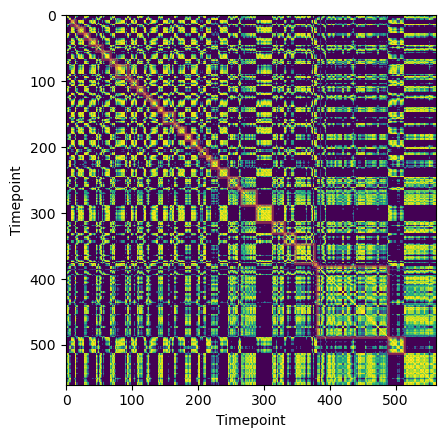

These plots show the measure of fit (left) and the state transitions over time (right).
Note that we purposely use the best fit after a minimum of 10 boundaries in order to ensure we have some meaningful states.


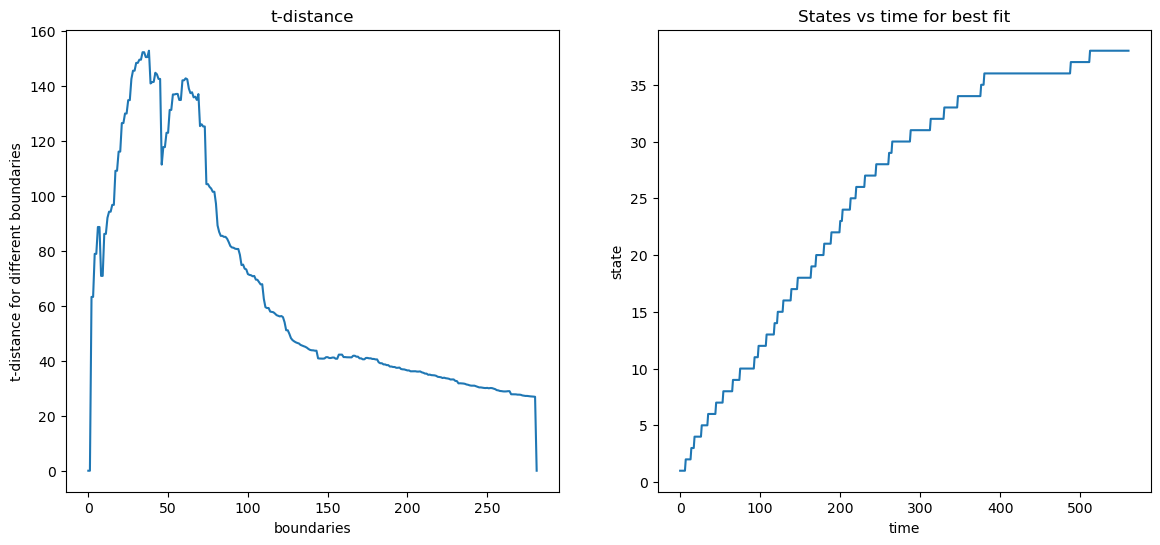

This plot shows a histogram of pattern correlations. This visualises the correlation between the segmented states, which is the measure we will next use to combine separate states.


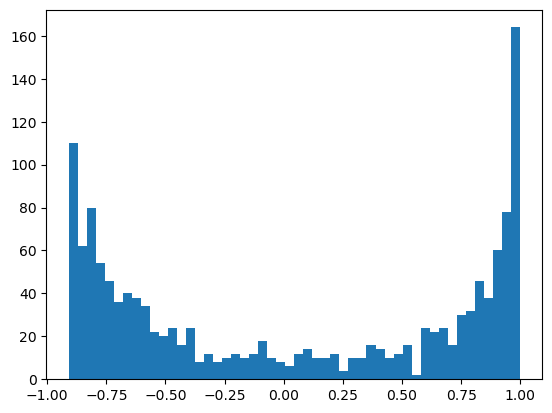

In [54]:
plot_gsbs_results(GSBS_model, time_series)

#### Finding unique states

The following cell will go through the GSBS segmented states and reduce them to a unique set of states.\
It does this by comparing the states using their correlation and merging states that have a correlation higher than the given threshold.

In [55]:
# You can alter the threshold value to change the resulting number of unique states
merged_states = merge_similar_states(GSBS_model, threshold=0.97)

Reduced the number of unique states from 38 to 13


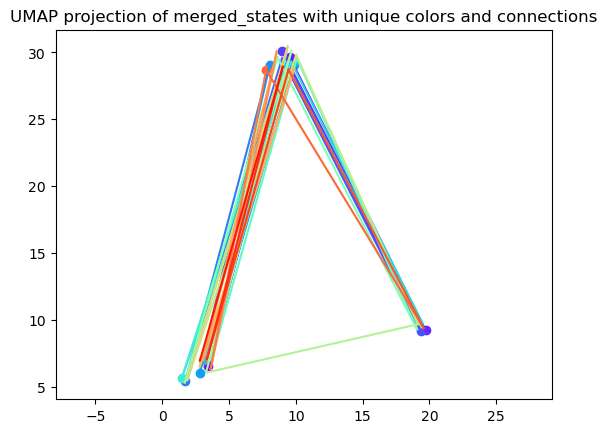

In [276]:
# Initialize and fit UMAP
reducer = UMAP(n_components=2)
embedding = reducer.fit_transform(merged_states)

# Plotting
unique_states = set()
colors = plt.cm.rainbow(np.linspace(0, 1, len(merged_states)))

for i in range(len(merged_states)):
    state = tuple(merged_states[i])  # Convert to tuple to make it hashable
    if state not in unique_states:
        plt.scatter(embedding[i, 0], embedding[i, 1], color=colors[i])
        unique_states.add(state)
    if i < len(merged_states) - 1:
        plt.plot(embedding[i:i+2, 0], embedding[i:i+2, 1], color=colors[i])  # Connect with lines

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of merged_states with unique colors and connections')
plt.show()

The next function will print the start and ending frame for all instances of each unique state. \
This helps us to easier analyse and find the states/behaviours in the original video data. \
This function also 'upsamples' the data using the labelled downsampled data. \
It takes the state labels from the downsampled data and inserts them into the original sized dataset. It then fills in the missing values based on the nearest state label. \
By doing this, we ensure that we have state labels for the full frame dataset and not just for the time-downsampled frames.

In [56]:
state_data, state_labels, labelled_dataset = print_frames_per_state(downsampled_data, dataset, GSBS_model, merged_states)

Sequences for state '5.0': 
Start frame: 0, end frame: 130
Start frame: 1851, end frame: 1950
Start frame: 2771, end frame: 2930
Start frame: 4891, end frame: 5210
Start frame: 6251, end frame: 6590
Start frame: 10231, end frame: 11249

Sequences for state '11.0': 
Start frame: 131, end frame: 270
Start frame: 691, end frame: 890
Start frame: 1951, end frame: 2150
Start frame: 2351, end frame: 2430
Start frame: 2931, end frame: 3270
Start frame: 3771, end frame: 3990
Start frame: 4251, end frame: 4390
Start frame: 9751, end frame: 10230

Sequences for state '0.0': 
Start frame: 271, end frame: 350
Start frame: 2151, end frame: 2350
Start frame: 3271, end frame: 3390

Sequences for state '9.0': 
Start frame: 351, end frame: 530
Start frame: 2571, end frame: 2770
Start frame: 3391, end frame: 3590
Start frame: 4611, end frame: 4890
Start frame: 5751, end frame: 6250

Sequences for state '1.0': 
Start frame: 531, end frame: 690
Start frame: 6931, end frame: 7510

Sequences for state '8.0'

The following plots show the sequence of states and what these states look like over time(frames)

This plot shows states by colour, showing their order and recurrence throughout the data:


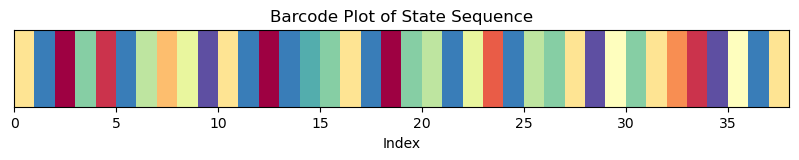

This plot shows the states over the frames and includes markers to show the freezing frames:


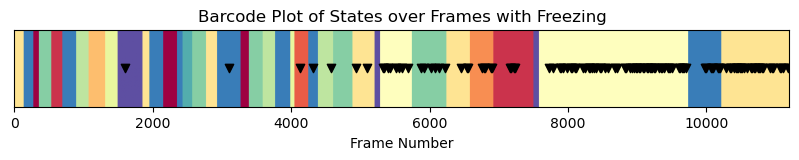

In [57]:
plot_barcodes(merged_states, downsampled_data)

#### Visualising original video frames by state
The two cells below will allow you to choose a specific state and then visualise the video frames belonging to that state for you.

In [62]:
#### Run this cell! ####
state_options = np.unique(state_labels)
dropdown_state = widgets.Dropdown(options=state_options, description='State:')
print("Which state would you like to see the video frames of?")
display(dropdown_state)

Which state would you like to see the video frames of?


Dropdown(description='State:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=0)

**Make sure to run the cell above to choose which state to view!**

In [76]:
labels_temp = labelled_dataset['state_label']

In [77]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

state = dropdown_state.value
show_frames_for_cluster(input_video_path, state, labelled_dataset, labels_temp)

cluster_11_frames\cluster_11.mp4


## Behavioural profiles

### HDBSCAN results

In [46]:
embedding_result = joblib.load('../Results/Mouse 5.4/RNN_embedding_result.joblib')
cluster_labels = joblib.load('../Results/Mouse 5.4/RNN_cluster_labels.joblib')

The following plots show 10 individual barcodes for the 10 largest clusters, and one large barcode with all clusters shown. 
The barcodes also show the freezing frames using black markers.
The invidiual plot titles show two percentages: Freezing Rate in Cluster (FRC) and Cluster Freezing Contribution (CFC). 
- FRC is the percentage of frames within a cluster that are freezing frames. 
- CFC is the percentage of total freezing frames that belong to a specific cluster.


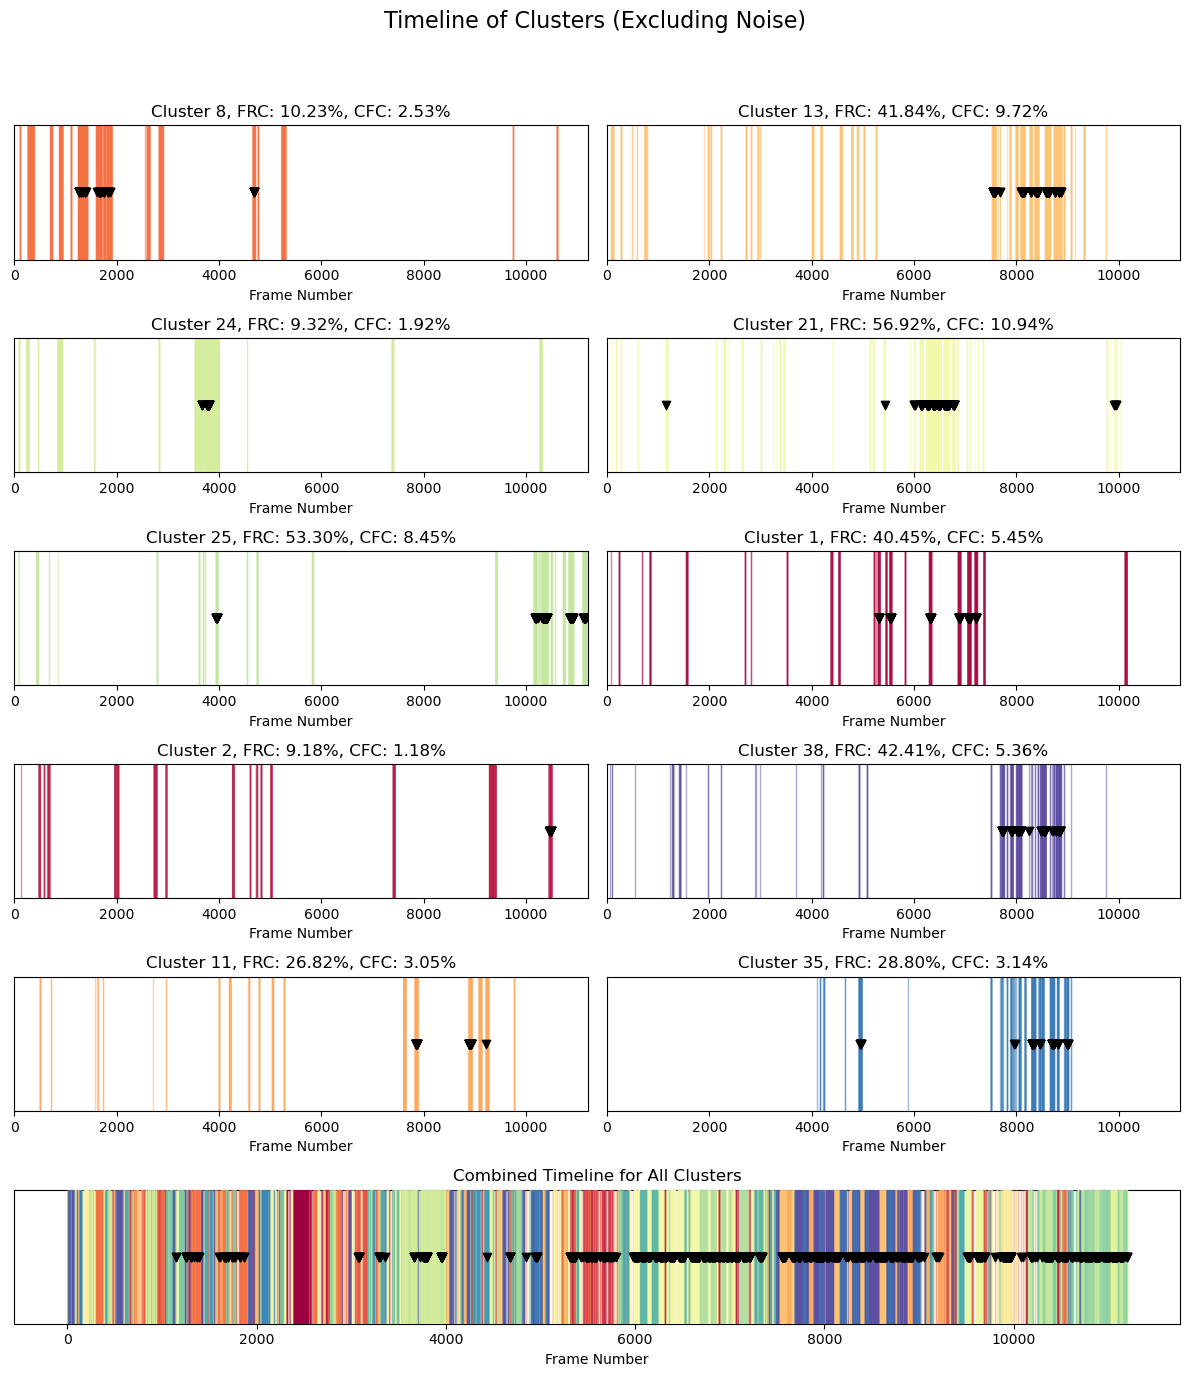

This chord diagram shows all the connections between the different clusters.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
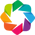

These plot shows all transitions between frames (in 3D and 2D).


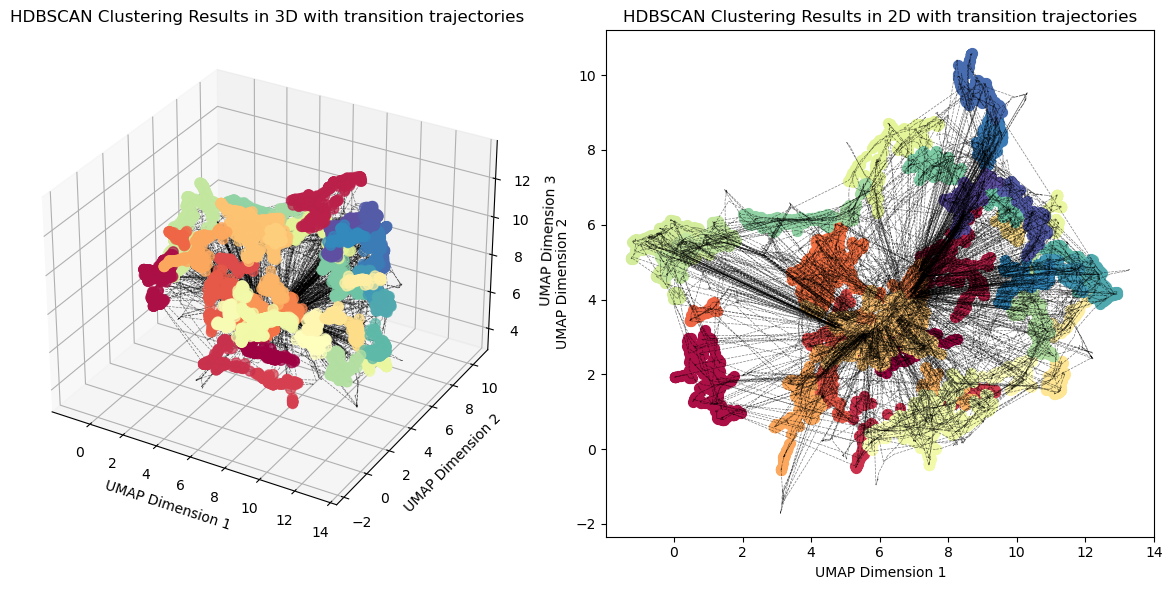

This transition matrix is another way of viewing the connections between the clusters.
The values in the squares show the amount of transitions between the current and target cluster and the total amount of transitions from this current cluster to all clusters (within brackets).


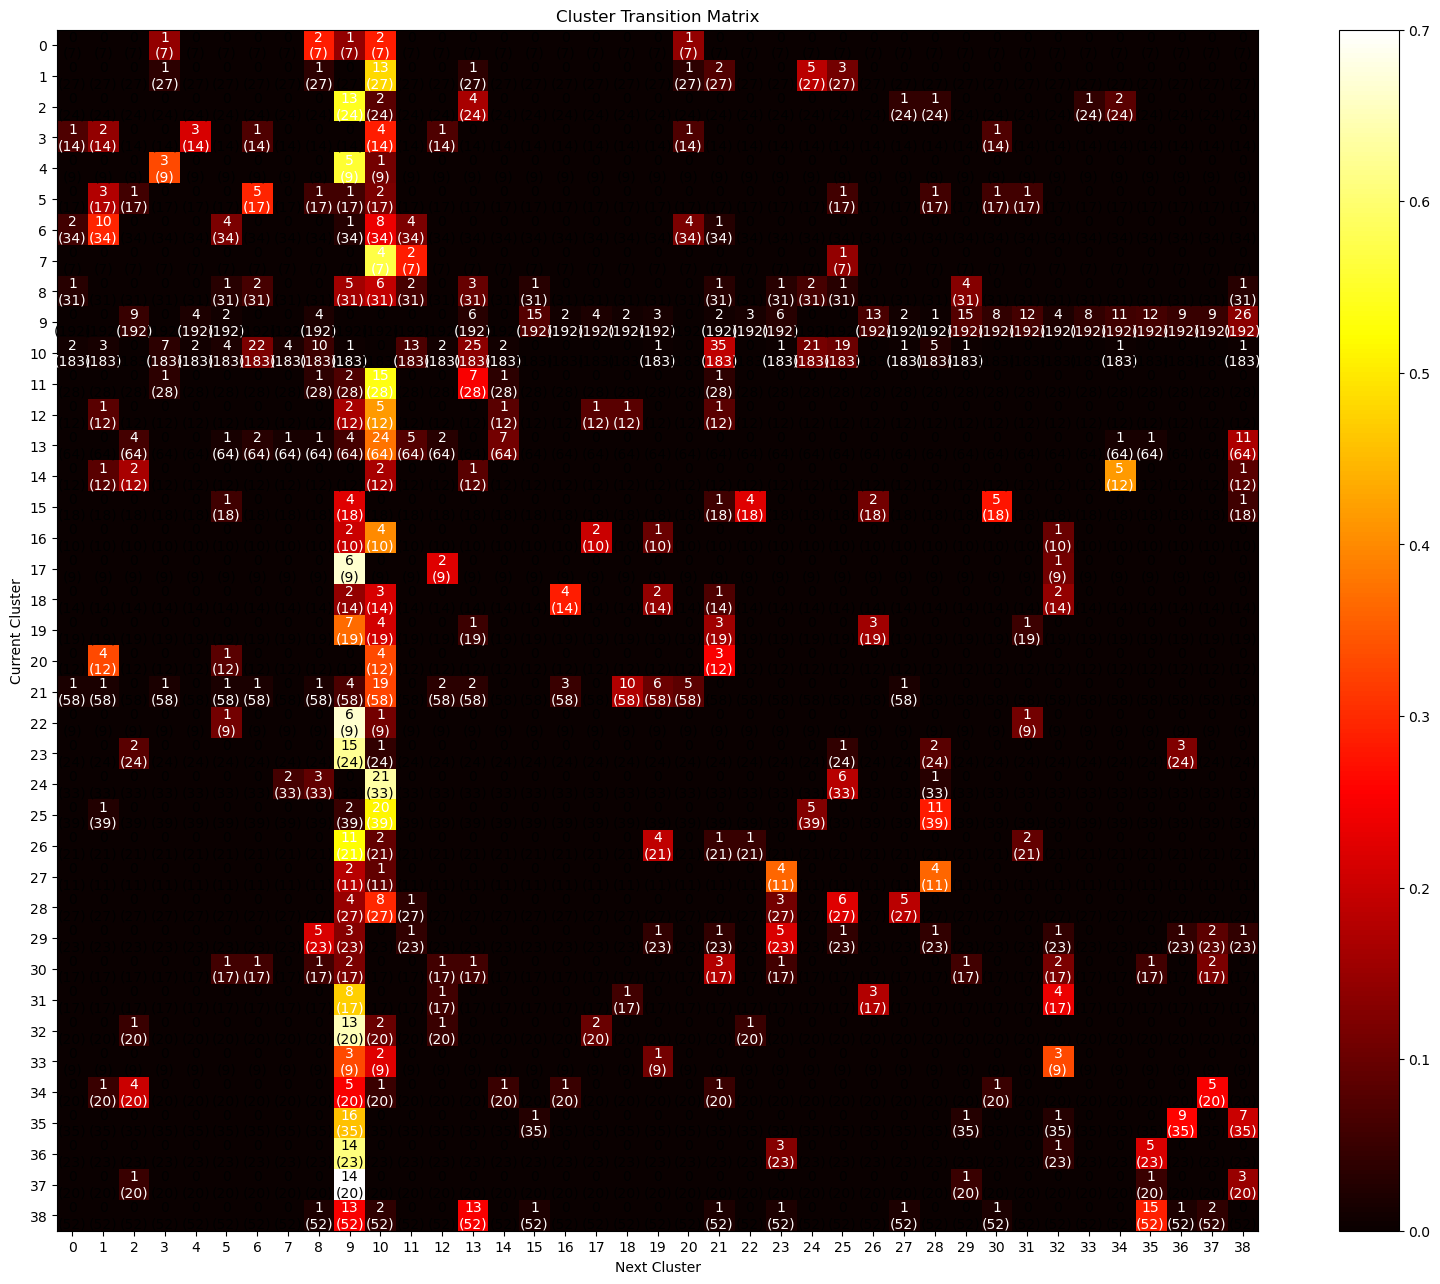

In [47]:
plot_hdbscan_bp(dataset, embedding_result, cluster_labels)

### GSBS results

This plot shows states by colour, showing their order and recurrence throughout the data:


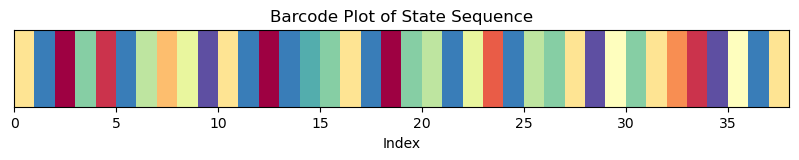

This plot shows the states over the frames and includes markers to show the freezing frames:


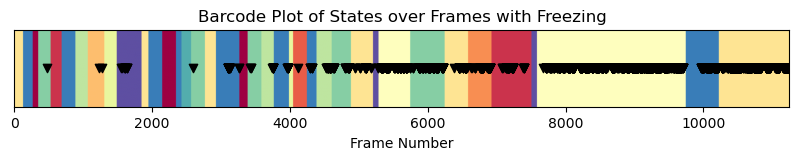

This chord diagram shows all the connections between the different states


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
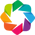

This transition matrix is another way of viewing the connections between the states.
The values in the squares show the amount of transitions between the current and target state and the total amount of transitions from this current state to all states (within brackets).


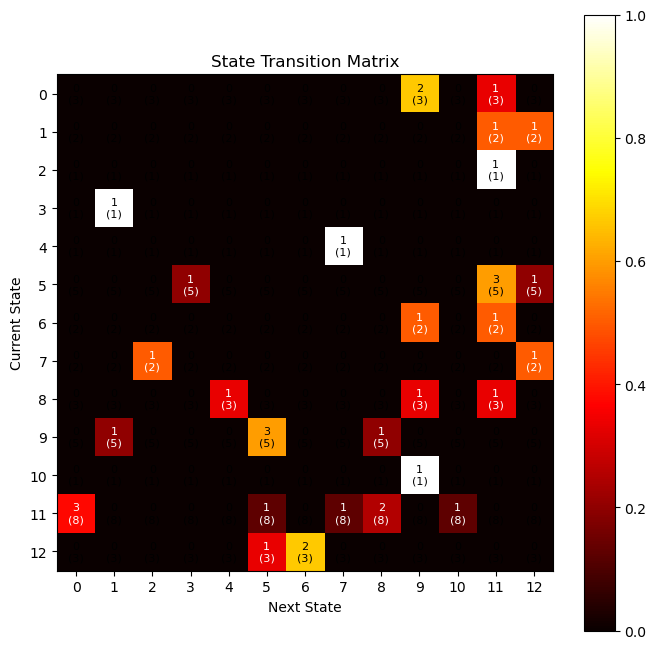

This plot shows a state transition graph where the states are the nodes and the transitions are the lines.
The transition weight is shown in the thickness of the lines (and the printed values).


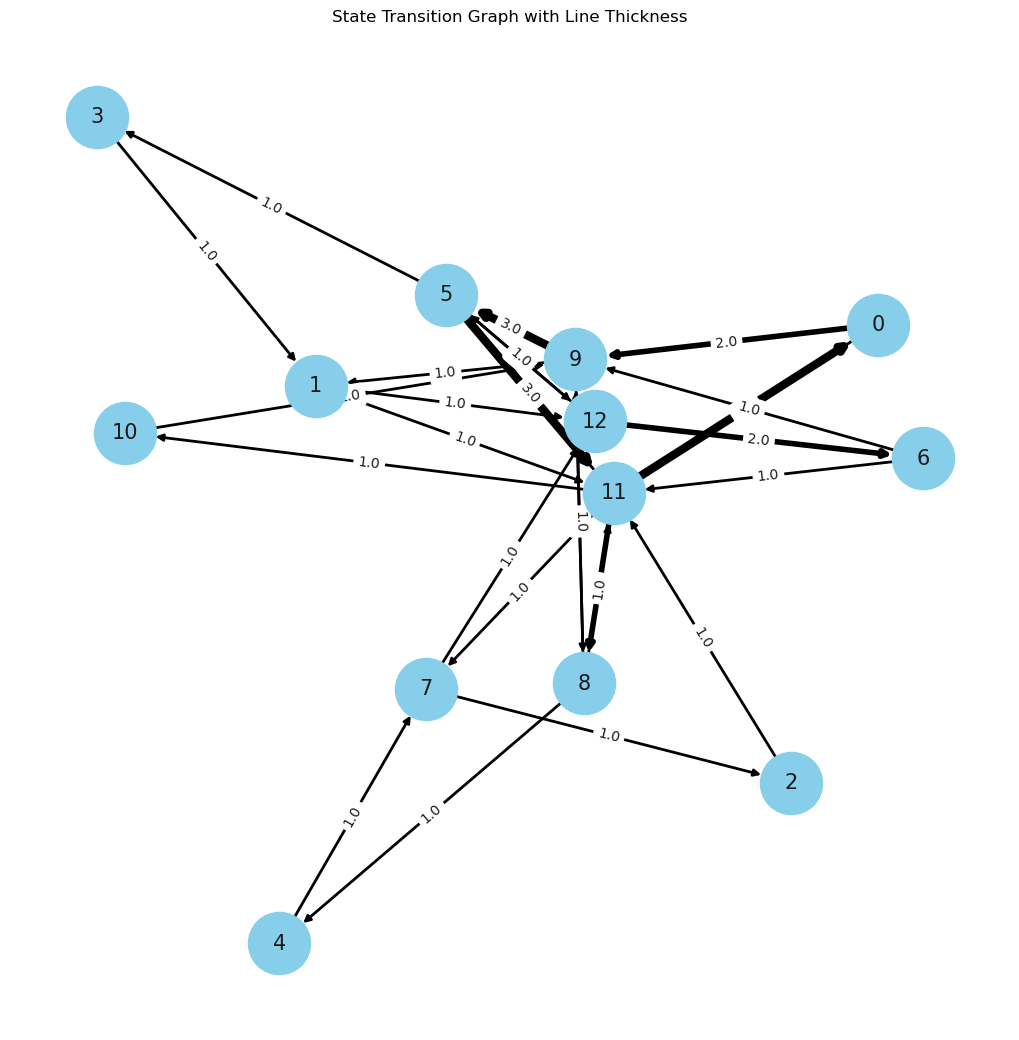

Here we'll print all recurring patterns and where they occur in the order of states:

Pattern: (5, 11), Occurrences at indices: [0, 10, 16]
Pattern: (11, 0), Occurrences at indices: [1, 11, 17]
Pattern: (0, 9), Occurrences at indices: [2, 18]
Pattern: (11, 8), Occurrences at indices: [5, 24]
Pattern: (9, 5), Occurrences at indices: [15, 26, 30]
Pattern: (12, 6), Occurrences at indices: [28, 34]
Pattern: (5, 11, 0), Occurrences at indices: [0, 10, 16]
Pattern: (11, 0, 9), Occurrences at indices: [1, 17]
Pattern: (5, 11, 0, 9), Occurrences at indices: [0, 16]


In [58]:
recurring_patterns = plot_gsbs_bp(merged_states, labelled_dataset)

In [59]:
#### Run this cell! ####
pattern_options = list(recurring_patterns.keys())
dropdown_pattern = widgets.Dropdown(options=pattern_options, description='Pattern:')
print("Which pattern would you like to see the video frames of?")
display(dropdown_pattern)

Which pattern would you like to see the video frames of?


Dropdown(description='Pattern:', options=((5, 11), (11, 0), (0, 9), (11, 8), (9, 5), (12, 6), (5, 11, 0), (11,…

In [80]:
# The input video path should point to the directory containing the mouse mp4 videos titled as: Animal_11_4DLC_resnet50_Freezing_07-2020Sep29shuffle1_100000_filtered_labeled.mp4
input_video_path = "../labelled_videos" # Change this if your directory is somewhere else

pattern = dropdown_pattern.value
show_frames_for_sequence(input_video_path, pattern, labelled_dataset, state_data)